# SBINN training with simulated data and importance sampling


This notebook contains the code to train an SBINN model using simulated data. In particular, it implements various methods to improve the convergence of vanilla PINN/SBINN such as:
- the importance sampling algorithm as introduced by Nabian et al. (2021) in "Efficient Training of Physics-Informed Neural Networks via Importance Sampling". This allows to improve the SBINN model convergence for challenging ODE system such as stiff systems or with regions of near discontinuity.
- the approach using the gradient of the physics loss to avoid the trivial solution. "How to Avoid Trivial Solutions in Physics-Informed Neural Networks" by R. Leiteritz and D. Pflüger. **Note**: not applicable if stiff points, useful for faster training (allows to reduce number of training samples).
- the LA-PINN as alternative to vanilla PINN that fits individual weights to each sampled point for the physics loss. It also adapts the weights of other loss components. "Loss-attentional physics-informed neural networks" by Song et al. (2024) (to do)
- the VS-PINN as alternative to vanilla PINN that uses variable scaling (local projections of NN solution to reduce sharpness of variations) to address stiffness problems. "VS-PINN: A Fast and efficient training of physics-informed neural networks using variable-scaling methods for solving PDEs with stiff behavior" by Seungchan Ko and Sang Hyeon Park (2024) (arxiv).
- the lbPINN as alternative to vanilla PINN that automatically adapts the loss weights during training based on ML estimation ("Self-adaptive loss balanced Physics-informed neural networks" by Xiang et al. (2022))
- the ReLoBRaLo model that forces each loss component to improve at the same pace by balancing loss terms relatively to their improvements from the start of the training. "Multi-Objective Loss Balancing for Physics-Informed Deep Learning" by R. Bischof and M. A. Kraus.

In [3]:
# Import necessary packages and set the seed for reproducibility
from PIL import Image
import numpy as np
import random
import os
import torch
import torch.nn as nn
torch.manual_seed(123)
import matplotlib.pyplot as plt
import scipy

## SBINN setup

### 1. Helper functions for plotting and saving model results

In [4]:
def plot_training_result(t, y, t_data, y_data, y_nn, epoch=None, title=None, ylim=None):
    """ Plots the neural network function approximation during training.
    """
    plt.figure(figsize=(8,4))

    # Plot ground truth
    plt.plot(t, y, color="grey", linewidth=2, alpha=0.8, label="Exact solution")

    # Plot NN prediction
    plt.plot(t, y_nn, color="tab:blue", linewidth=4, alpha=0.8, label="Neural network prediction")
    plt.xlabel("Time [s]")
    if title is not None:
        plt.title(title)
    if ylim is not None:
        plt.ylim(ylim)

    # Plot training data
    plt.scatter(t_data, y_data, s=60, color="tab:orange", alpha=0.4, label='Training data')

    # Remove spines
    ax = plt.gca()
    ax.spines[["top", "right"]].set_visible(False)

    # Plot legend
    plt.legend(bbox_to_anchor =(1.4, 0.5), loc="center right", frameon=False, fontsize="medium", 
               title=f"Training step: {epoch}", title_fontsize="large") 

In [ ]:
def plot_physics_loss(t, loss, y_nn, t_gt, y_gt, epoch=None, title=None):
    """ Plots the physics loss value for each currently evaluated sample point.
    """

    fig = plt.figure(figsize=(8,4))
    ax = fig.gca()
    ax.plot(t, torch.log(loss), color="black", linewidth=2, alpha=0.8, label="Physics LogLoss")
    ax.set_xlim(0, 250)
    ax.set_xlabel("Time [s]")
    if title is not None:
        ax.set_title(title)

    # Remove spines and y axis
    ax.spines[["top", "right"]].set_visible(False)
    ax.set_ylabel("Loss")
    ax2 = ax.twinx()
    ax2.plot(t_gt, y_nn, color="blue", label="Neural Network prediction", linewidth=4, alpha=0.4)
    ax2.plot(t_gt, y_gt, color="red", label = "Ground truth", linewidth=4, alpha=0.4)
    ax2.set_ylabel("y(t)")
    ax2.spines[["top"]].set_visible(False)
    
    # Plot legend
    fig.legend(bbox_to_anchor =(1.55, 0.5), loc="center right", frameon=False, fontsize="medium", 
               title=f"Training step: {epoch}", title_fontsize="large")

In [163]:
def plot_losses(losses, weights, filename=None):

    nb_plots = np.sum(np.array(list(weights.values())) != 0)
    fig, axs = plt.subplots(nb_plots, 1, sharex=True, figsize=(6, 8), tight_layout=True)

    colour = ["blue", "orange", "green"]
    i = 0
    for name in losses:
        if weights[name] != 0:
            loss = np.array(losses[name])
            axs[i].plot(np.log(loss), color=colour[i], label=name+" LogLoss")
            axs[i].set_ylabel("LogLoss")
            axs[i].spines["top"].set_visible(False)
            axs[i].legend()
            ax2 = axs[i].twinx()
            ax2.plot(np.log(loss*weights[name]), color=colour[i])
            ax2.set_ylabel("Log Weighted Loss", rotation=270, labelpad=20)
            ax2.spines["top"].set_visible(False)
            i += 1
    #plt.tight_layout()
    plt.xlabel("Epochs")
    plt.suptitle("Comparison of data, physics and gradient loss scale", y=1.02, fontsize="large")

    if filename is not None:
        fig.savefig(filename, bbox_inches="tight", pad_inches=0.1, dpi=100, facecolor="white")
        

In [7]:
def plot_sample_distrib(t, epoch, title=None):
    
    plt.figure(figsize=(8,4))
    plt.plot(t, "o", label="Timepoint sample")
    plt.ylabel("Time [s]")
    plt.xlabel("Sample")
    if title is not None:
        plt.title(title)
    ax = plt.gca()
    ax.spines[["top", "right"]].set_visible(False)

    # Plot legend
    plt.legend(bbox_to_anchor =(1.4, 0.5), loc="center right", frameon=False, fontsize="medium", 
               title=f"Training step: {epoch}", title_fontsize="large")
    

In [8]:
def save_gif_PIL(outfile, files, fps=5, loop=0):
    """ Saves sequence of training plots as GIF image.
    """

    # Open PIL images and delete original file
    imgs = [Image.open(file).resize((930, 351)) for file in files]
    for file in files:
        os.remove(file)

    # Create GIF animation
    imgs[0].save(fp=outfile, format='GIF', append_images=imgs[1:], save_all=True, duration=int(1000/fps), loop=loop)

### 2. ODE-specific functions 

In [79]:
def gef_ode(t, y, kinact, gef0, light_on, light_off):
    """ Returns right hand size of the ODE system of GEF activation upon light stimulation.
    """
    # Define the light signal function
    signal_f = 0
    assert len(light_on) == len(light_off)
    for i in range(len(light_on)):
        signal_f += ((np.tanh(100 * (t-light_on[i]))/2 - 
                      np.tanh(100 * (t-light_off[i]))/2))
    
    
    return (kinact * (gef0 * (1+signal_f) - y))

In [80]:
def gef_residuals(t_minibatch, yhp, kinact, gef0, light_on, light_off, save_graph=True):
    """ Returns the ODE residuals of the GEF activation system upon light stimulation for the 
    physics loss computation during SBINN training.
    """
    
    # Derive the first derivative of the ODE wrt sampled points
    dy = torch.autograd.grad(yhp, t_minibatch, torch.ones_like(yhp), create_graph=save_graph)[0]

    # Define the light signal function
    signal_f = 0
    assert len(light_on) == len(light_off)
    for i in range(len(light_on)):
        signal_f += ((torch.tanh(100 * (t_minibatch-light_on[i]))/2 - 
                      torch.tanh(100 * (t_minibatch-light_off[i]))/2))
    
    return (dy - kinact * (gef0 * (1+signal_f) - yhp))

In [81]:
def gef_activation(kinact, gef0, t):
    """ Defines the analytical solution of the GEF ODE. 
    """
    
    assert 0 < gef0
    y  = gef0 * (1 - torch.exp(-kinact * t))
    
    return y

In [12]:
def damped_oscillator_residuals(x_minibatch, yhp, d, w0):
    """ Returns right hand size of the ODE system of a 1D damped harmonic oscillator for the 
    ODE residuals computation during PINN training.
    """

    # Define parameters of ODE
    mu, k = 2 * d, w0**2

    # Derive the first and second derivative of the ODE wrt sampled points
    dy = torch.autograd.grad(yhp, x_minibatch, torch.ones_like(yhp), create_graph=True)[0]
    dy2 = torch.autograd.grad(dy,  x_minibatch, torch.ones_like(dy),  create_graph=True)[0]

    return dy2 + mu * dy + k * yhp

In [13]:
def damped_oscillator(d, w0, x):
    """ Defines the analytical solution to the 1D underdamped harmonic oscillator problem. 
    Equations taken from: https://beltoforion.de/en/harmonic_oscillator/ """
    
    assert d < w0
    w = np.sqrt(w0**2-d**2)
    phi = np.arctan(-d/w)
    A = 1/(2*np.cos(phi))
    cos = torch.cos(phi+w*x)
    exp = torch.exp(-d*x)
    y  = exp*2*A*cos
    
    return y

In [14]:
def rhoa_dynamics_ode(t, y, param):
    """ Returns right hand size of the ODE system of GEF activation upon light stimulation.
    """
    # Define the light signal function
    signal_f = ((np.tanh(100 * (t-param["light_on"]))/2 - np.tanh(100 * (t-param["light_off"]))/2))

    gef = y[:,0]
    rhoa = y[:,1]
    gap = y[:,2]

    u = np.zeros_like(y)
    u[:,0] =  param["kinact"] * (param["gef0"] * (1+signal_f) - gef)
    u[:,1] =  ((param["kcat_gef"] * (gef-param["gef0"]) * (10-rhoa) / (param["km_gef"] + (10-rhoa))) - 
               (param["kcat_gap"] * (gap-param["gap0"]) * rhoa / (param["km_gap"] + rhoa)))
    u[:,2] = ((param["kcat_nar"] * (rhoa-1) * (np.tanh(100*(rhoa-1))- np.tanh(100*(rhoa-10)))/2
                     * (10-gap)) / (param["km_nar"] + (10-gap)) + param["kinact_gap"] * (param["gap0"]-gap))
    
    return u

In [15]:
def rhoa_dynamics_residuals(t_minibatch, yhp, param, save_graph=True):
    """ Returns the ODE residuals of the GEF activation system upon light stimulation for the 
    physics loss computation during SBINN training.
    """
    
    # Derive the first derivative of the ODE wrt sampled points
    dy = torch.autograd.grad(yhp, t_minibatch, torch.ones_like(yhp), create_graph=save_graph)[0]
    
    return (dy - torch.tensor(rhoa_dynamics_ode(t_minibatch, yhp, param)))

### 3. Neural Network architecture

In [92]:
class FFN(nn.Module):
    """ Defines a feedforward fully connected network.
    """
    
    def __init__(self, in_dim, out_dim, h_dim, num_layers):
        super().__init__()
        activation = nn.Tanh
        self.fcs = nn.Sequential(*[
                        nn.Linear(in_dim, h_dim),
                        activation()])
        self.fch = nn.Sequential(*[
                        nn.Sequential(*[
                            nn.Linear(h_dim, h_dim),
                            activation()]) for _ in range(num_layers-1)])
        self.fce = nn.Linear(h_dim, out_dim)
        
    def forward(self, x):
        x = self.fcs(x)
        x = self.fch(x)
        x = self.fce(x)
        return x

### 4. Importance sampling algorithm

In [24]:
def importance_sampling(indices, seeds, ode_param, residuals_fn, model, space_size):
    """ Implements the importance sampling method from Nabian et al. (2021). The probability distribution of the sample
    domain is made proportional to the loss term. Elements of the sample space with higher loss have higher probability 
    to be sampled for the next minibatch.
    """
    # Determine physics loss at seed points
    yhp = model(seeds)
    physics = residuals_fn(seeds, yhp, **ode_param, save_graph=False)
    loss = physics**2

    # Normalise the loss values so that they sum to one
    probabilities = loss / torch.sum(loss)

    # Cut the sample space into intervals centered around each each sample
    low_i = torch.zeros_like(indices)
    low_i[1:] = indices[0:-1] + (indices[1:]-indices[0:-1])/2

    up_i = torch.zeros_like(indices)
    up_i[0:-1] = low_i[1:]
    up_i[-1] = space_size

    intervals = (up_i-low_i)
    assert torch.sum(intervals) == space_size

    # Apply the estimated probability distribution to the intervals (~ nearest-neighbour)
    distribution = torch.repeat_interleave(probabilities, intervals)
    
    return distribution.detach()

### 5. ReLoBRaLo algorithm

In [251]:
def relobralo_weight_update(current_loss, previous_loss, start_loss,
                            previous_w, temperature=1, decay_rate=0.99, bernoulli_rate=0.999):

    rho = torch.bernoulli(torch.tensor(bernoulli_rate, dtype=torch.float))

    #print("current_loss ", current_loss)
    #print("start_loss ", start_loss)
    #print(torch.div(current_loss, start_loss * temperature))

    intermediate_w0 = 2 * torch.nn.functional.softmax(torch.div(current_loss, start_loss * temperature),
                                                 dim=0)
    #print(intermediate_w0)
    intermediate_w = 2 * torch.nn.functional.softmax(torch.div(current_loss, previous_loss * temperature),
                                                dim=0)

    lookback_w = rho * previous_w + (1-rho) * intermediate_w0
    #print(lookback_w)
    updated_w = decay_rate * lookback_w + (1-decay_rate) * intermediate_w
    #print(updated_w)
    
    return updated_w

### 6. Simulate data form ODE analytical solution

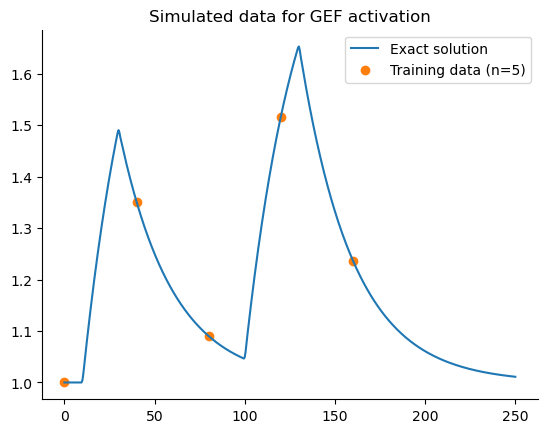

In [103]:
# Set parameter value for ODE
kinact, gef0 = 0.034, 1
light_on, light_off = [10, 100], [30, 130]

# Get the analytical solution over the full domain
ode_sol = scipy.integrate.solve_ivp(fun=gef_ode, t_span=(0, 250), 
                              y0=np.array([1]), 
                              method="LSODA",
                              max_step=0.5,
                              args=(kinact, gef0, light_on, light_off))
t = torch.tensor(ode_sol.t, dtype=torch.float).view(-1,1)
y = torch.tensor(ode_sol.y.squeeze()).view(-1,1)

# Slice out a small number of points from the LHS of the domain
t_data = t[::20][0:20:4]
y_data = y[::20][0:20:4]

# Plot training data
plt.figure()
plt.plot(ode_sol.t, ode_sol.y.squeeze(), label="Exact solution")
plt.scatter(t_data, y_data, color="tab:orange", label=f"Training data (n={len(t_data)})")
plt.title("Simulated data for GEF activation")
ax = plt.gca()
ax.spines[["top", "right"]].set_visible(False)
plt.legend()
plt.show()

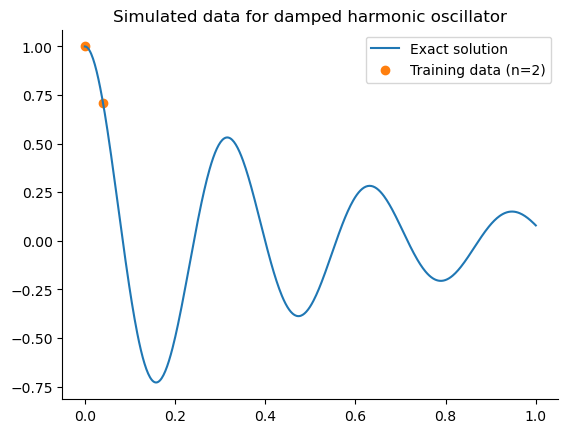

In [17]:
d, w0 = 2, 20

# Get the analytical solution over the full domain
x_oscill = torch.linspace(0,1,500).view(-1,1)
y_oscill = damped_oscillator(d, w0, x_oscill).view(-1,1)

# Slice out a small number of points from the domain
x_oscill_data = x_oscill[0:200:20]
y_oscill_data = y_oscill[0:200:20]
x_oscill_data = x_oscill_data[0:2,]
y_oscill_data = y_oscill_data[0:2,]

plt.figure()
plt.plot(x_oscill, y_oscill, label="Exact solution")
plt.scatter(x_oscill_data, y_oscill_data, color="tab:orange", 
            label=f"Training data (n={len(x_oscill_data)})")
plt.title("Simulated data for damped harmonic oscillator")
ax = plt.gca()
ax.spines[["top", "right"]].set_visible(False)
plt.legend()
plt.show()


In [ ]:
# Set parameter value for ODE
param = {
    "kinact_gef": 0.034,
    "gef0": 0.25,
    "kcat_gef": 1.26,
    "km_gef": 5,
    
}

# Get the analytical solution over the full domain
ode_sol = scipy.integrate.solve_ivp(fun=gef_ode, t_span=(0, 250), 
                              y0=np.array([1]), 
                              method="LSODA",
                              max_step=0.5,
                              args=(kinact, gef0, light_on, light_off))
t = torch.tensor(ode_sol.t, dtype=torch.float).view(-1,1)
y = torch.tensor(ode_sol.y.squeeze()).view(-1,1)

# Slice out a small number of points from the LHS of the domain
t_data = t[::25]
y_data = y[::25]

# Plot training data
plt.figure()
plt.plot(ode_sol.t, ode_sol.y.squeeze(), label="Exact solution")
plt.scatter(t_data, y_data, color="tab:orange", label=f"Training data (n={len(t_data)})")
plt.title("Simulated data for GEF activation")
ax = plt.gca()
ax.spines[["top", "right"]].set_visible(False)
plt.legend()
plt.show()

## Train SBINN model

In [ ]:
def train_sbinn(t_data, y_data, t, y, weights={"Data": 1, "Physics": 1, "Gradient": 0}, 
                size_batch=1000, size_space=int(1e4), n_epochs=int(1e4),
                residuals_fn=None, ode_param=None, plot_title="", ylim=None):

    # Define size of minibatch
    size_batch = size_batch

    # Normalize the space domain to [0, 1]
    #scaled_t = torch.div(t, (t[-1].item()-t[0].item()))
    #scaled_t_data = torch.div(t_data, (t[-1].item()-t[0].item()))
    
    # Initialise the sample space probability distribution
    size_space = size_space
    assert size_space % size_batch == 0
    sample_space_prob = torch.ones(size_space) / size_space
    sample_space = torch.linspace(t[0].item(), t[-1].item(), size_space)
    
    # Sample minibatch from sample space
    seed_indices, _ = torch.sort(torch.multinomial(input=sample_space_prob, num_samples=size_batch))
    seeds = sample_space[seed_indices].view(-1,1).requires_grad_(True)
    seeds_prob = sample_space_prob[seed_indices]

    # Define number of epochs
    n_epochs = n_epochs
    
    # Define model and ADAM optimizer
    model = FFN(1, 1, 64, 3)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-1)

    # Define learning rate scheduler to decrease learning rate by factor 0.1 if loss stops decreasing
    lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', threshold=0, 
                                                              factor=0.1, patience=5000, eps=1e-5)
    
    pred_plots = []
    physics_loss_plots = []
    losses = {"Data": [], "Physics": [], "Gradient": []}
    for i in range(n_epochs):

        optimizer.zero_grad()
        
        # Compute the "data loss" (use mean squared error)
        yh = model(t_data)
        loss1 = torch.mean((yh - y_data)**2)
        losses["Data"].append(loss1.detach())

        # Sample minibatch from sample space
        indices, _ = torch.sort(torch.multinomial(input=sample_space_prob, num_samples=size_batch))
        t_minibatch = sample_space[indices].view(-1,1).requires_grad_(True)
        #scaled_t_minibatch = torch.div(t_minibatch, (t[-1].item() - t[0].item()))
        
        # Predict y(t) for a minibatch
        yhp = model(t_minibatch)
    
        # Compute dy/dt of ODE
        physics = residuals_fn(t_minibatch, yhp, **ode_param)
        loss2 = torch.div(physics**2, sample_space_prob[indices].view(-1,1)) / size_space
        losses["Physics"].append(torch.mean(loss2).detach())

        # Compute gradient of the loss
        if weights["Gradient"] != 0:
            dphysics = torch.autograd.grad(loss2, t_minibatch, torch.ones_like(physics), create_graph=True)[0]
            loss3 = torch.max(dphysics**2, dim=0)[0]
            losses["Gradient"].append(loss3.detach())
        else:
            loss3 = 0

        # Perform ReLoBRaLo weight scaling
        #if i == 0:
        #    initial_loss = torch.cat((loss1.view(-1,1), torch.mean(loss2).view(-1,1)))
        #    previous_loss = initial_loss
        #    current_loss = initial_loss
        #    RLBL_weights = torch.tensor([1., 1.]).view(-1, 1)
        #else:
        #    current_loss = torch.cat((loss1.view(-1,1), torch.mean(loss2).view(-1,1)))
        #    RLBL_weights = relobralo_weight_update(current_loss.detach(), previous_loss.detach(), initial_loss.detach(), 
        #                                      RLBL_weights, temperature=1e-5, bernoulli_rate=0.999)
        #    previous_loss = current_loss

        # Backpropagate joint loss
        loss = weights["Data"] * loss1 + weights["Physics"] * torch.mean(loss2) + weights["Gradient"] * loss3
        #scaling_w = RLBL_weights * (torch.div(current_loss[0,0].item(), current_loss.detach()))
        #loss = (scaling_w[0,0] * current_loss[0,0] + scaling_w[1,0] * current_loss[1,0])

        # Update parameters and learning rate
        loss.backward()
        optimizer.step()
        lr_scheduler.step(loss)
        
        # Plot the results (loss and NN function) as training progresses
        if (i+1) % 500 == 0:
            print(f"Epoch: {i+1}")

            # Update sample space probabilities
            sample_space_prob = importance_sampling(seed_indices, seeds, ode_param, 
                                                    residuals_fn, model, size_space)
            
            # Predict y(t)
            yh = model(t).detach() 
            
            plot_training_result(t, y, t_data, y_data, yh, (i+1), title=plot_title,
                             ylim=ylim)
            pred_plot = f"Plots/pinn_{i+1:0>8}.png"
            plt.savefig(pred_plot, bbox_inches="tight", pad_inches=0.1, dpi=100, facecolor="white")
            pred_plots.append(pred_plot)
    
            plot_physics_loss(t_minibatch.detach(), 
                              (loss2).detach(), 
                              yh.detach(), t, y, (i+1), 
                              title="Physics loss per timepoint")
            physics_loss_plot = f"Plots/loss_{i+1:0>8}.png"
            plt.savefig(physics_loss_plot, bbox_inches="tight", pad_inches=0.1, dpi=100, 
                        facecolor="white")
            physics_loss_plots.append(physics_loss_plot)

            #sample_file = f"Plots/sample_{i+1:0>8}.png"
            #plt.savefig(sample_file, bbox_inches="tight", pad_inches=0.1, dpi=100, facecolor="white")
            #sample_files.append(sample_file) 
        
            if (i+1) % 5000 == 0:
                #for name in losses:
                #    plt.plot(np.array(losses[name]) * weights[name], label=name+" loss")
                #plt.xlabel("Epochs")
                #plt.ylabel("Loss")
                #plt.title("SBINN Loss curves")
                #plt.legend()
        
                plot_sample_distrib(t_minibatch.detach().numpy(), (i+1), title="Sample distribution")
                plot_losses(losses, weights=weights)
                #plot_losses(losses, weights= {"Data": scaling_w[0,0].item(), "Physics": scaling_w[1,0].item(),"Gradient": 0})
                plt.show()
            else:
                plt.close("all")

    return model, pred_plots, physics_loss_plots, losses

In [ ]:
size_batch = 30
size_space = int(1e4)
weights = {"Data": 1, "Physics": 1e-4, "Gradient": 1e-7}
n_epochs = int(3e4)
ode_param = {'d': 2, 'w0': 20}
plot_title= "Damped harmonic oscillator"
model, plot_files, loss_files, losses = train_sbinn(x_oscill_data, y_oscill_data, x_oscill, y_oscill, 
                                            weights, size_batch, size_space, n_epochs,
                                            damped_oscillator_residuals, ode_param, plot_title)

Epoch: 500
Epoch: 1000
Epoch: 1500
Epoch: 2000
Epoch: 2500
Epoch: 3000
tensor(0.0213, dtype=torch.float64, grad_fn=<AddBackward0>)
0.01
[0.01]
Epoch: 3500
Epoch: 4000
Epoch: 4500
Epoch: 5000


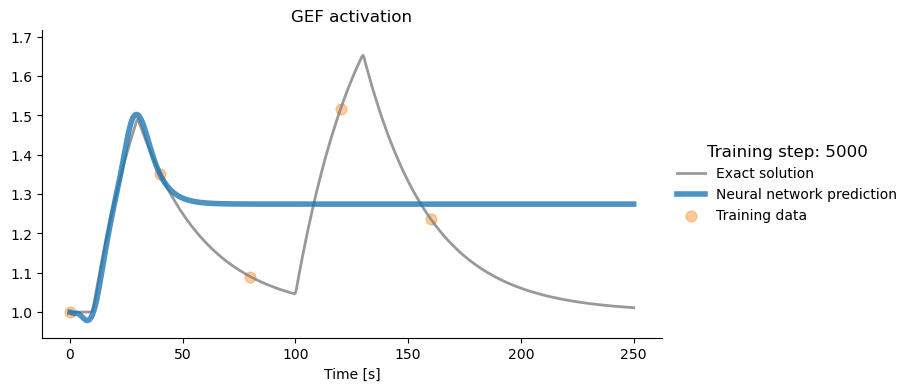

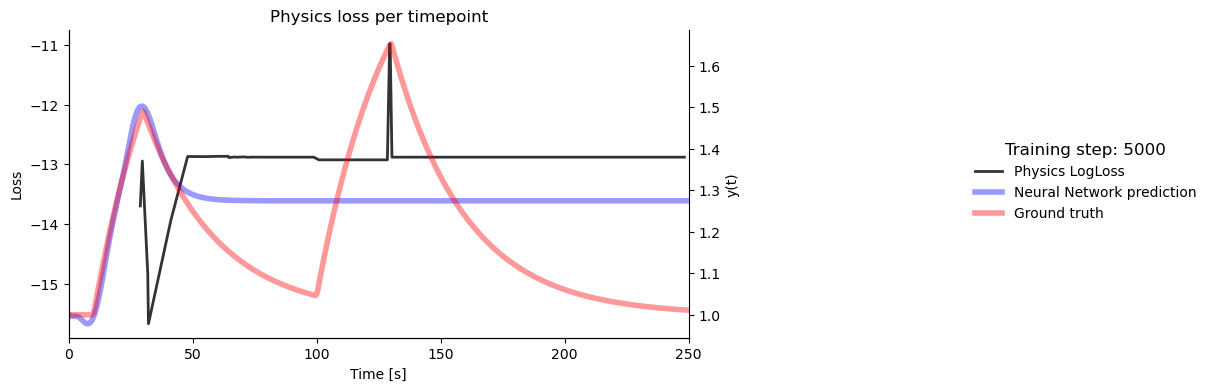

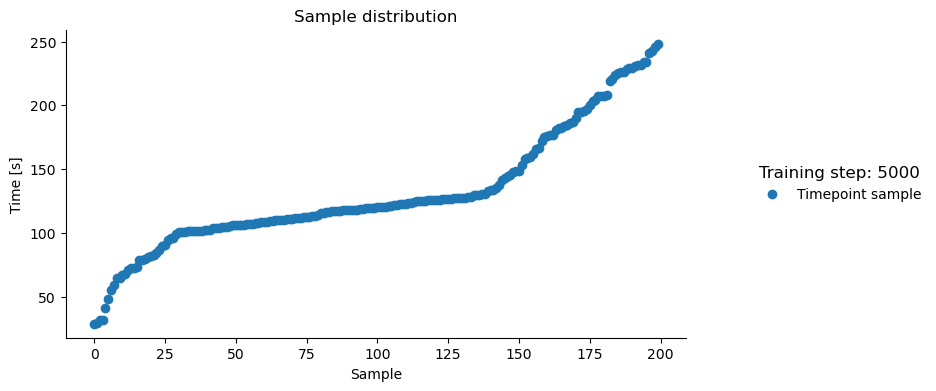

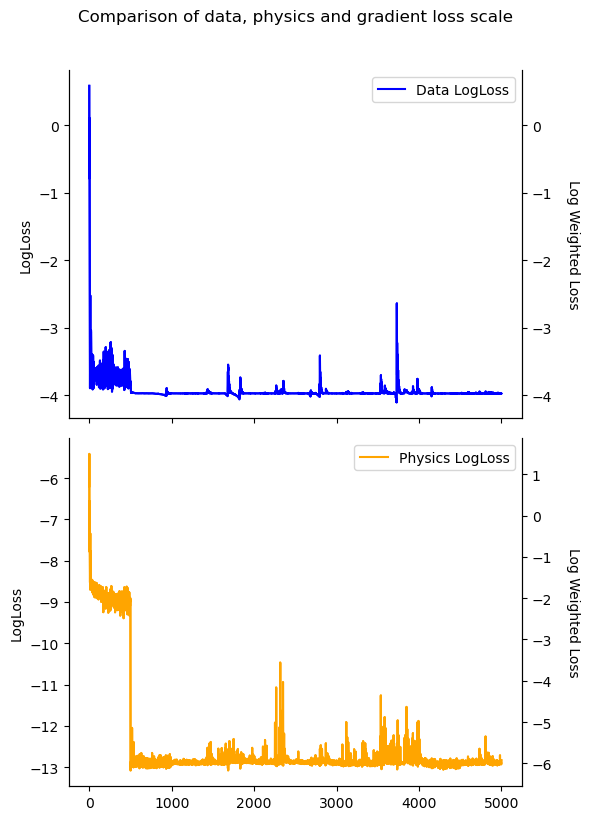

Epoch: 5500
Epoch: 6000
tensor(0.0218, dtype=torch.float64, grad_fn=<AddBackward0>)
0.01
[0.01]
Epoch: 6500
0.001
Epoch: 7000
Epoch: 7500
Epoch: 8000
Epoch: 8500
Epoch: 9000
tensor(0.0064, dtype=torch.float64, grad_fn=<AddBackward0>)
0.01
[0.001]
Epoch: 9500
Epoch: 10000


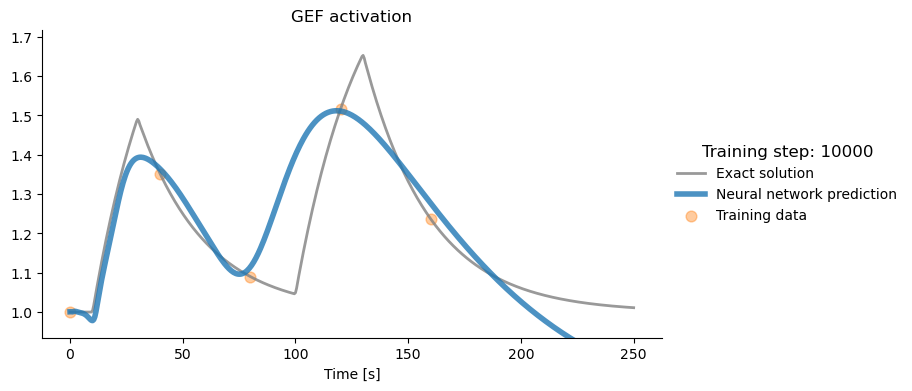

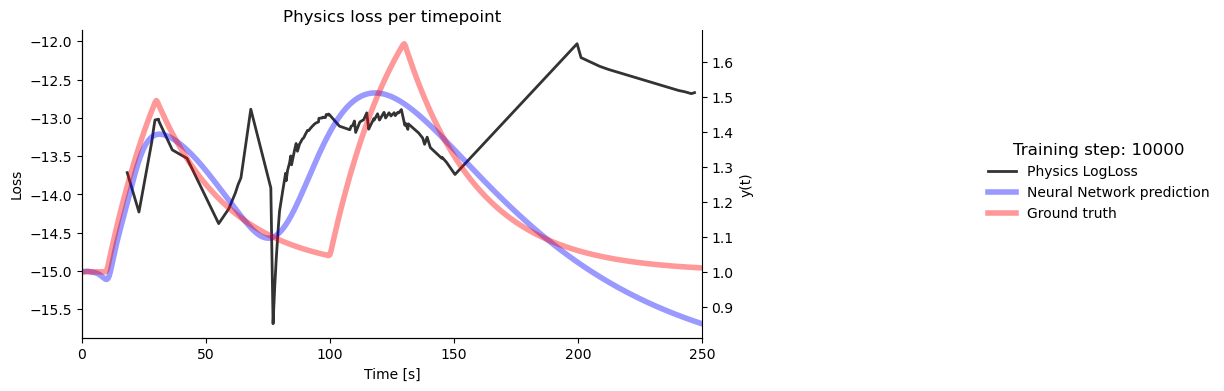

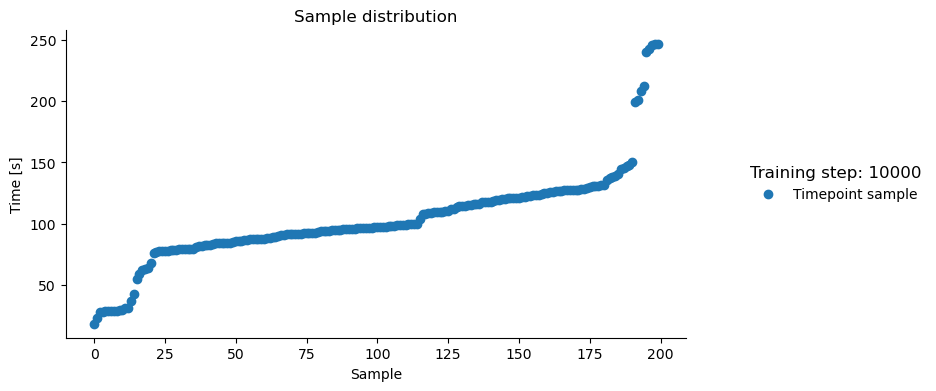

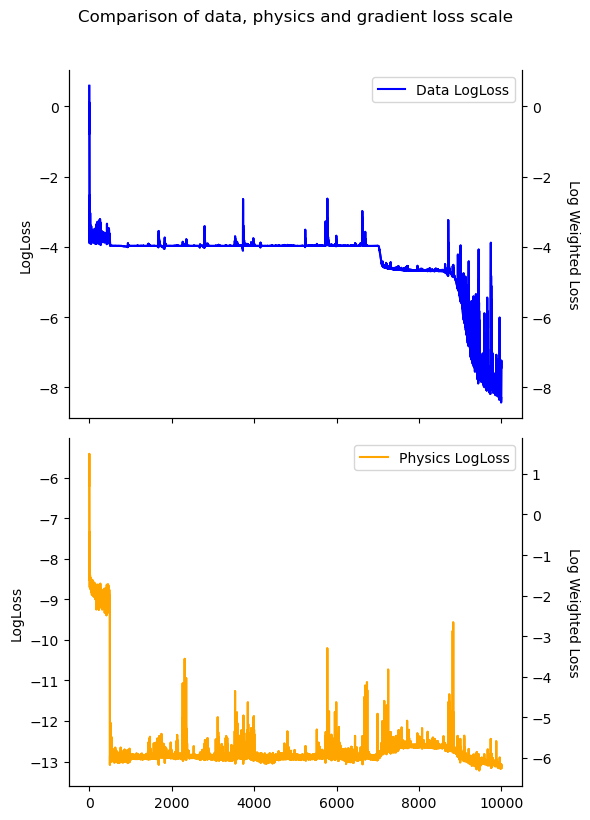

Epoch: 10500
Epoch: 11000
Epoch: 11500
Epoch: 12000
tensor(0.0018, dtype=torch.float64, grad_fn=<AddBackward0>)
0.01
[0.001]
Epoch: 12500
Epoch: 13000
Epoch: 13500
Epoch: 14000
Epoch: 14500
Epoch: 15000
tensor(0.0015, dtype=torch.float64, grad_fn=<AddBackward0>)
0.01
[0.001]


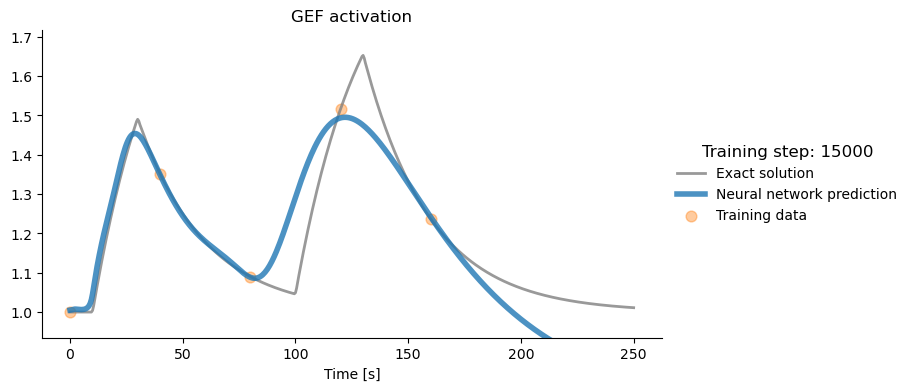

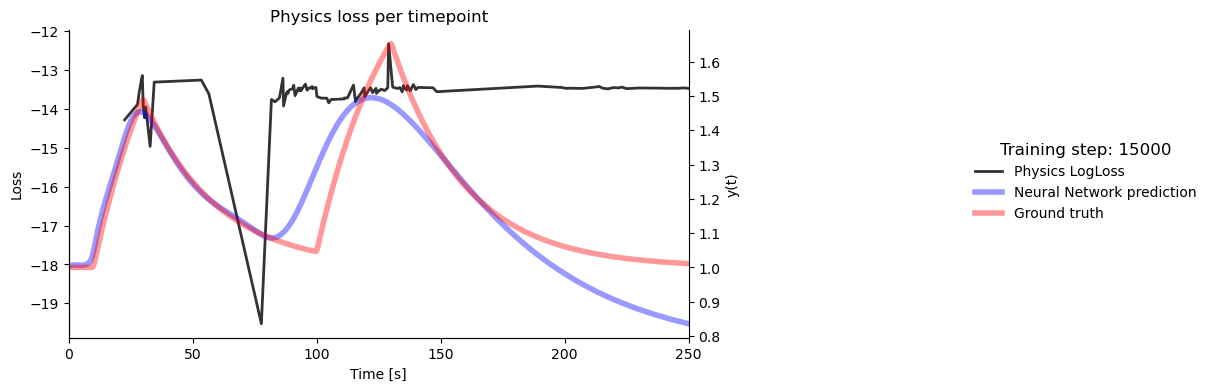

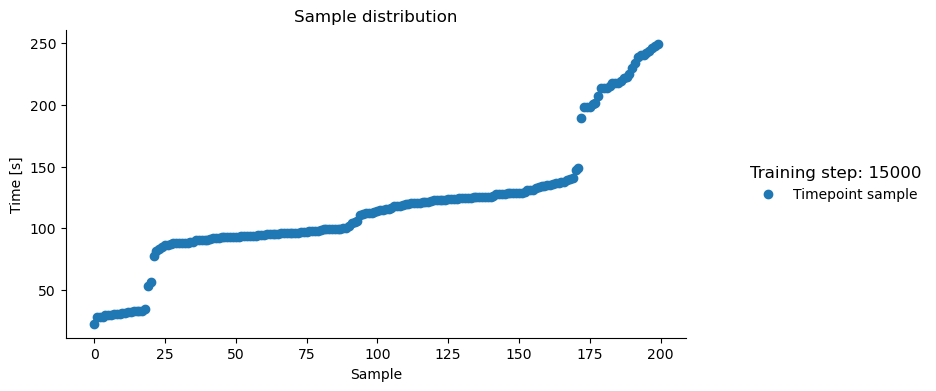

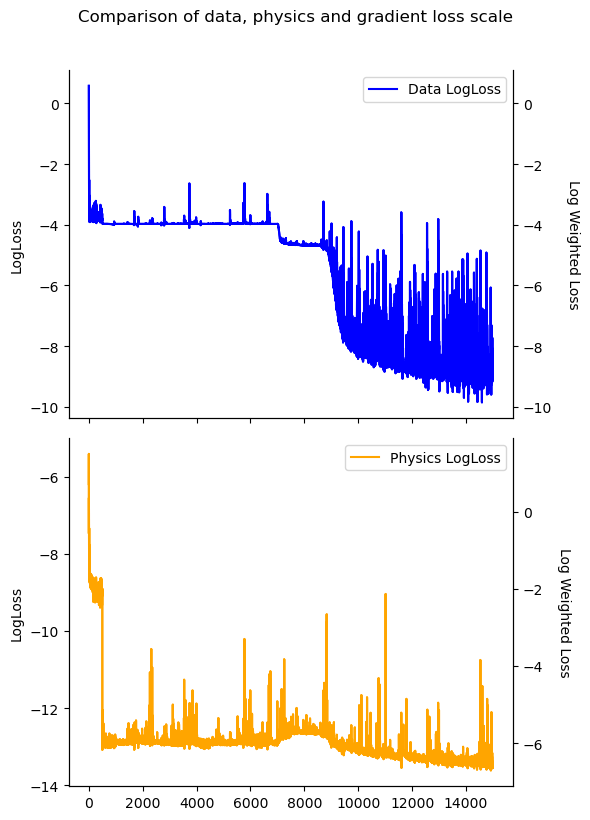

Epoch: 15500
Epoch: 16000
Epoch: 16500
Epoch: 17000
Epoch: 17500
Epoch: 18000
tensor(0.0016, dtype=torch.float64, grad_fn=<AddBackward0>)
0.01
[0.001]
Epoch: 18500
Epoch: 19000
Epoch: 19500
Epoch: 20000


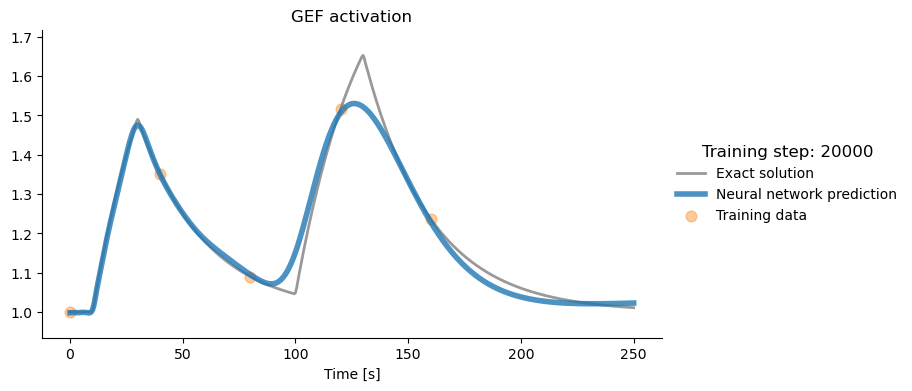

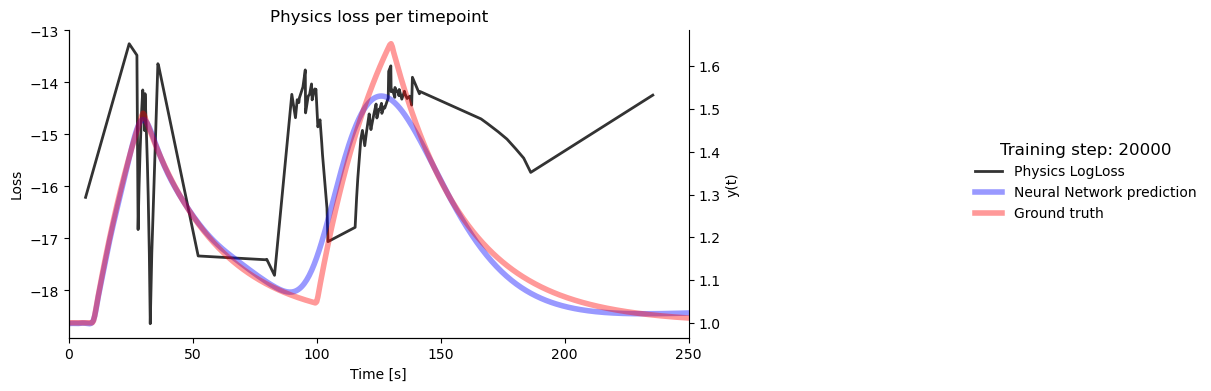

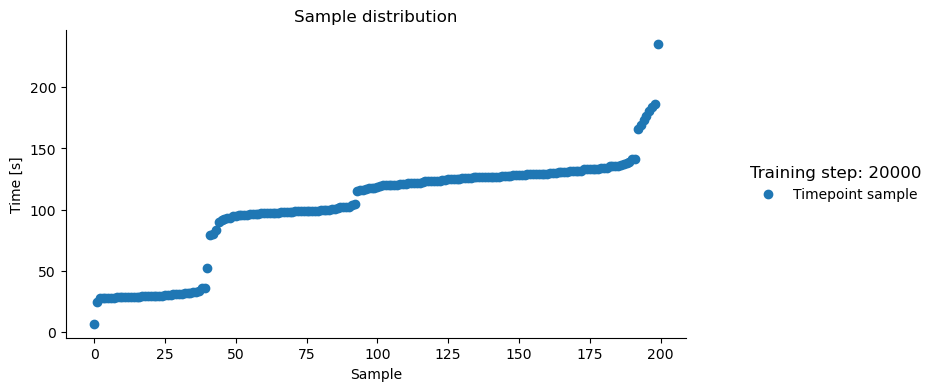

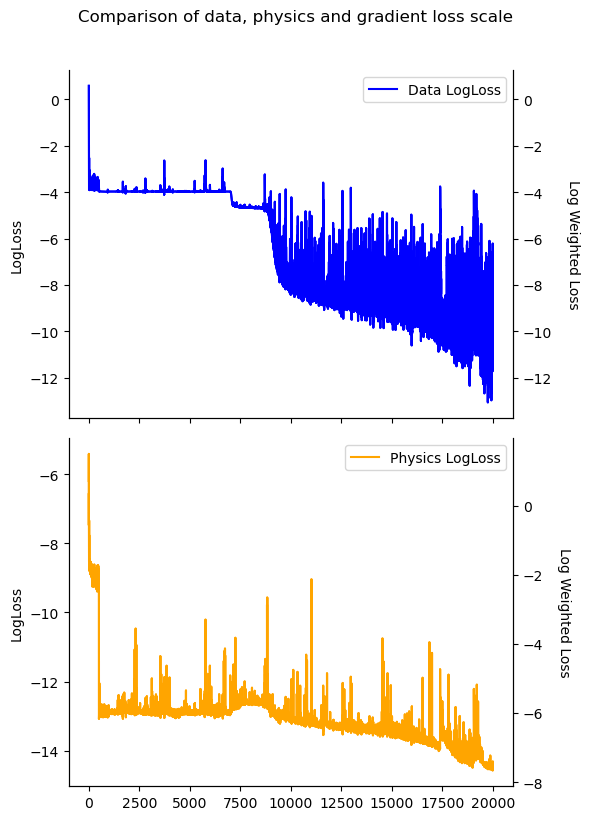

Epoch: 20500
Epoch: 21000
tensor(0.0008, dtype=torch.float64, grad_fn=<AddBackward0>)
0.01
[0.001]
Epoch: 21500
Epoch: 22000
Epoch: 22500
Epoch: 23000
Epoch: 23500
Epoch: 24000
tensor(0.0008, dtype=torch.float64, grad_fn=<AddBackward0>)
0.01
[0.001]
0.0001
Epoch: 24500
Epoch: 25000


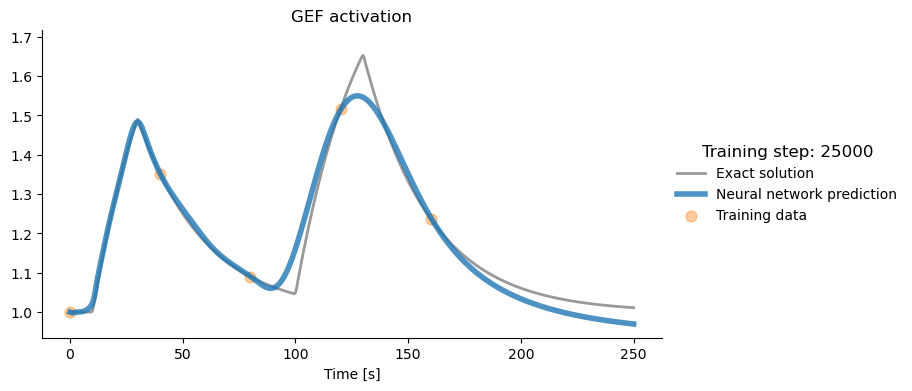

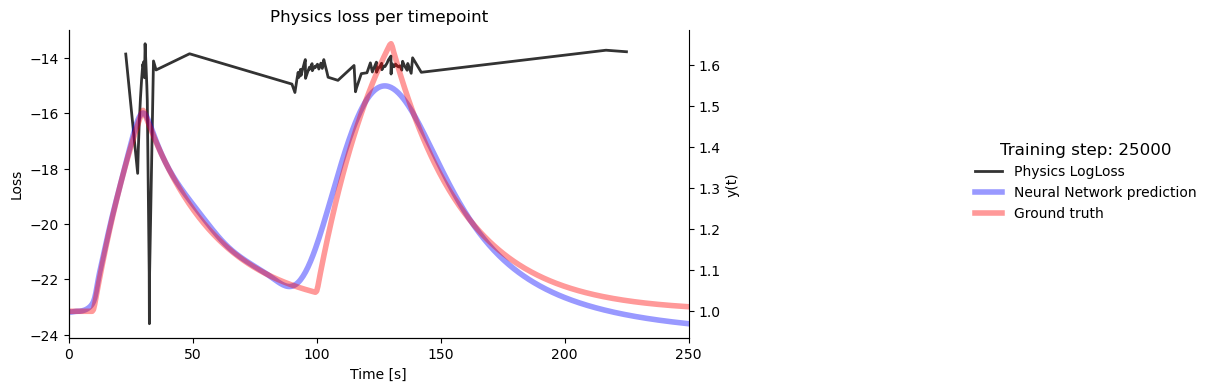

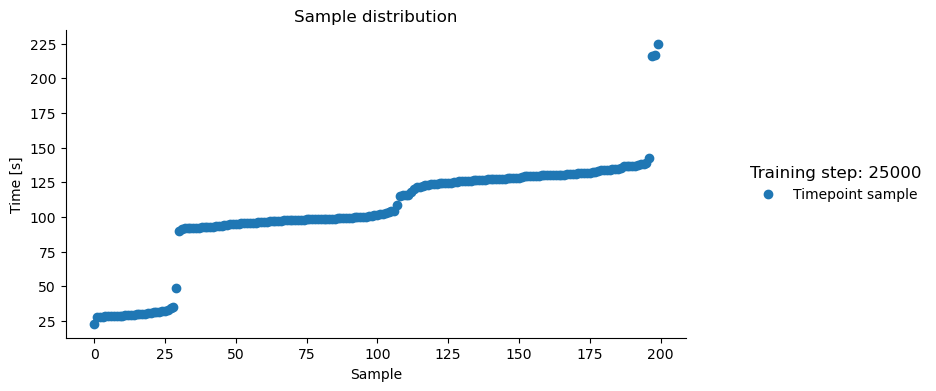

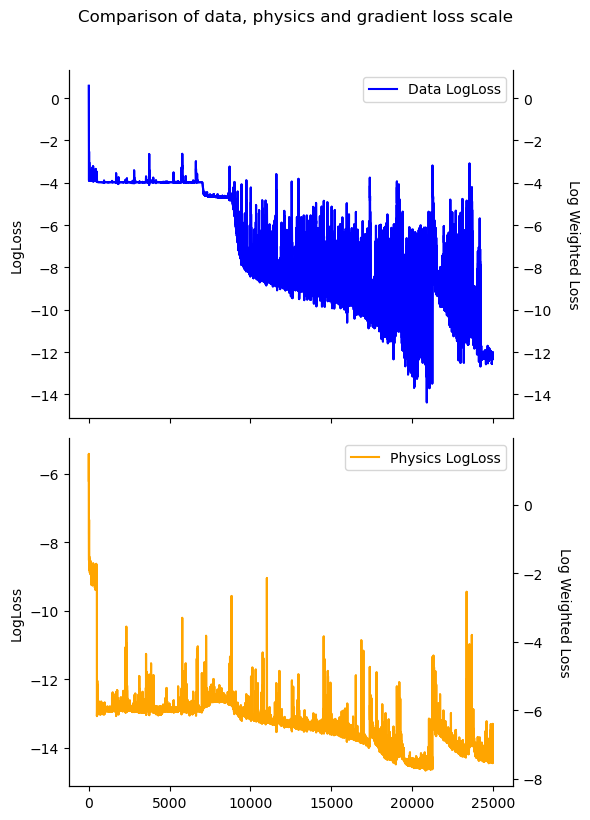

Epoch: 25500
Epoch: 26000
Epoch: 26500
Epoch: 27000
tensor(0.0005, dtype=torch.float64, grad_fn=<AddBackward0>)
0.01
[0.0001]
Epoch: 27500
Epoch: 28000
Epoch: 28500
Epoch: 29000
Epoch: 29500
Epoch: 30000
tensor(0.0004, dtype=torch.float64, grad_fn=<AddBackward0>)
0.01
[0.0001]


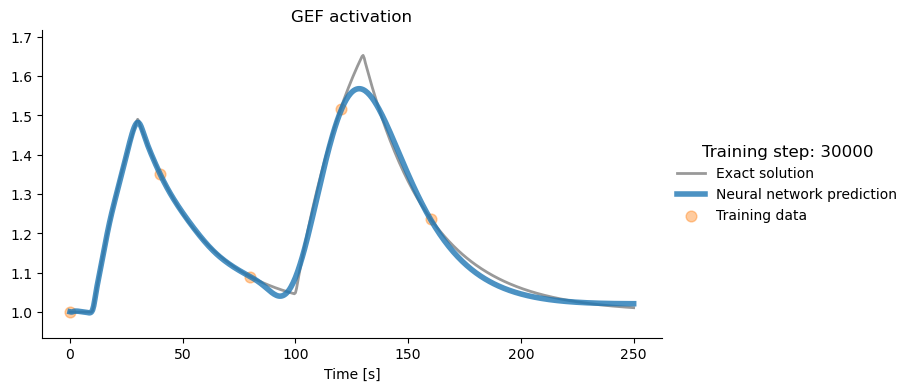

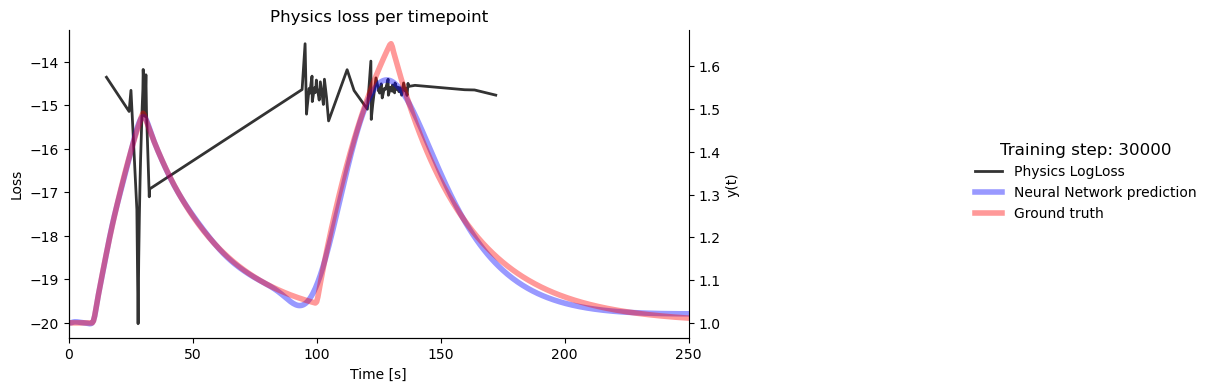

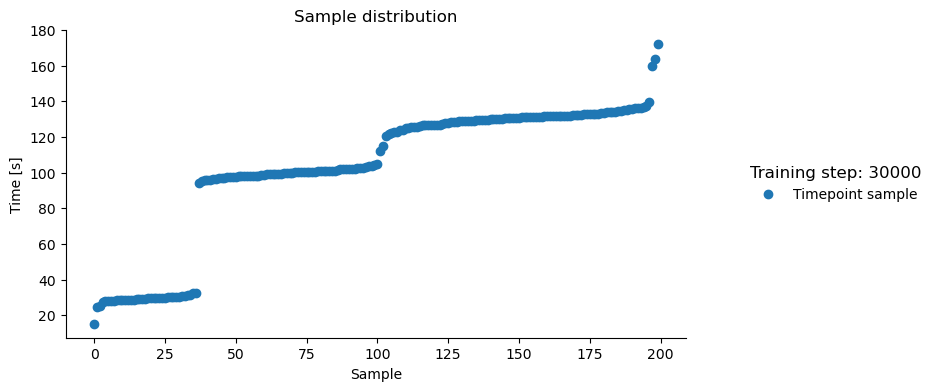

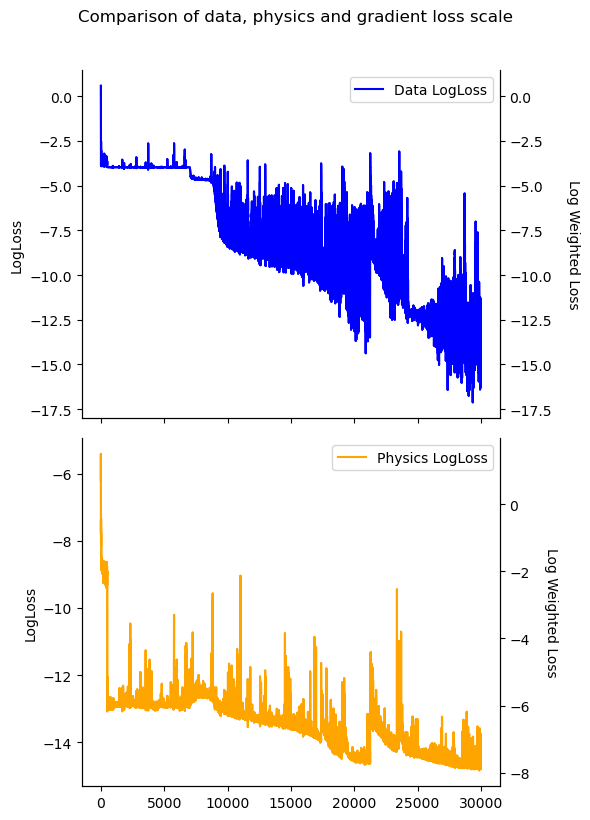

Epoch: 30500
Epoch: 31000
Epoch: 31500
Epoch: 32000
Epoch: 32500
Epoch: 33000
tensor(0.0004, dtype=torch.float64, grad_fn=<AddBackward0>)
0.01
[0.0001]
Epoch: 33500
1e-05
Epoch: 34000
Epoch: 34500
Epoch: 35000


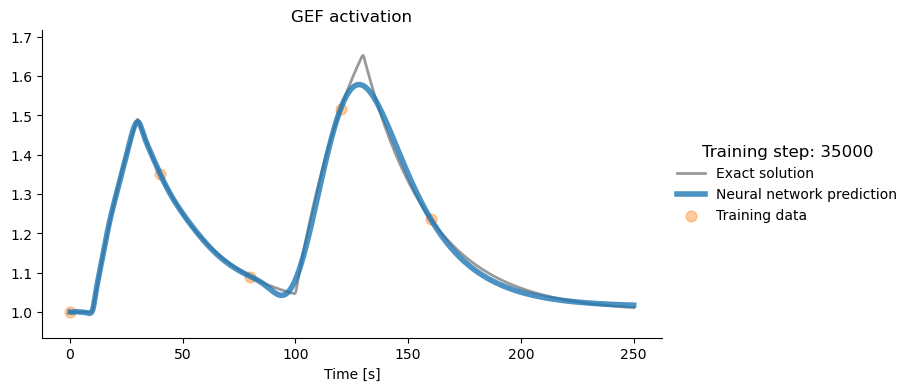

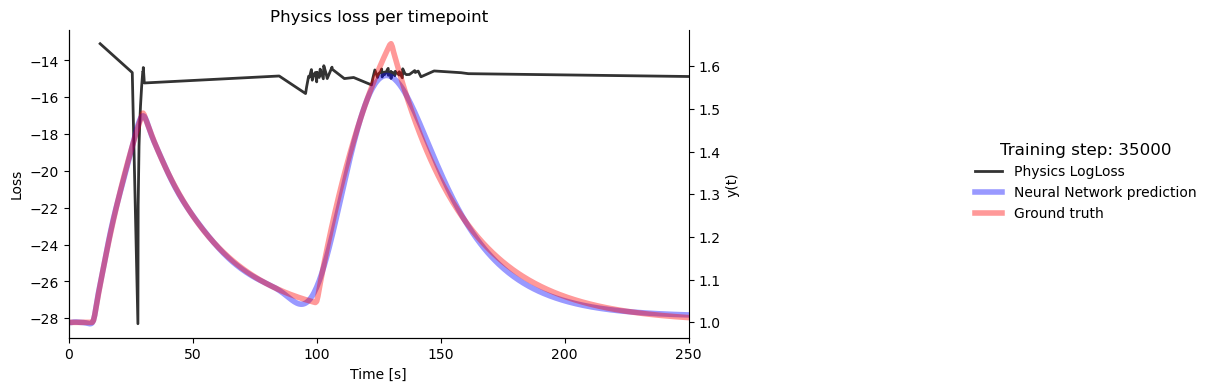

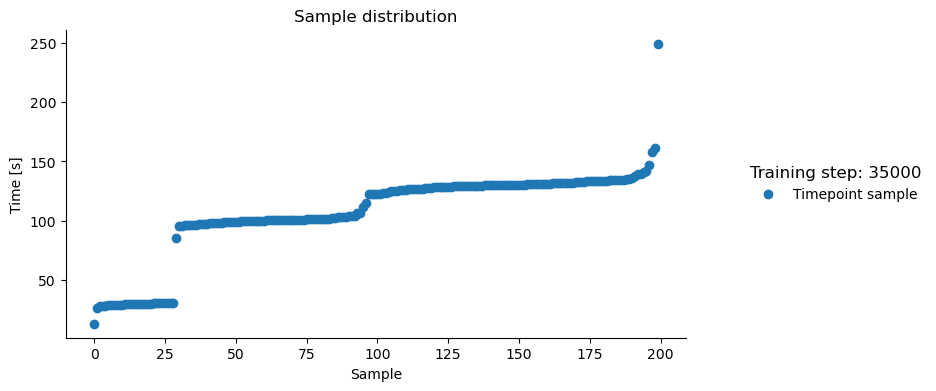

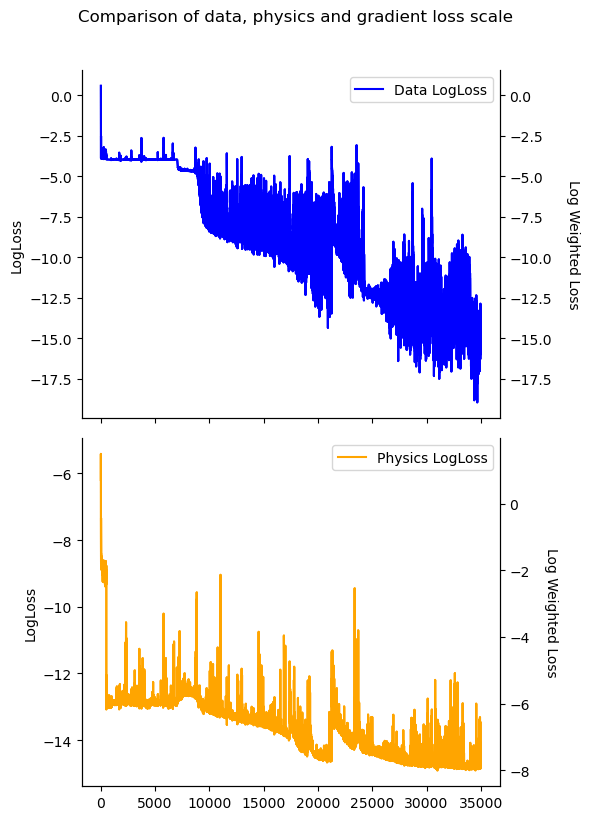

Epoch: 35500
Epoch: 36000
tensor(0.0004, dtype=torch.float64, grad_fn=<AddBackward0>)
0.01
[1e-05]
Epoch: 36500
Epoch: 37000
1.0000000000000002e-06
Epoch: 37500
Epoch: 38000
Epoch: 38500
Epoch: 39000
tensor(0.0004, dtype=torch.float64, grad_fn=<AddBackward0>)
0.01
[1.0000000000000002e-06]
Epoch: 39500
Epoch: 40000


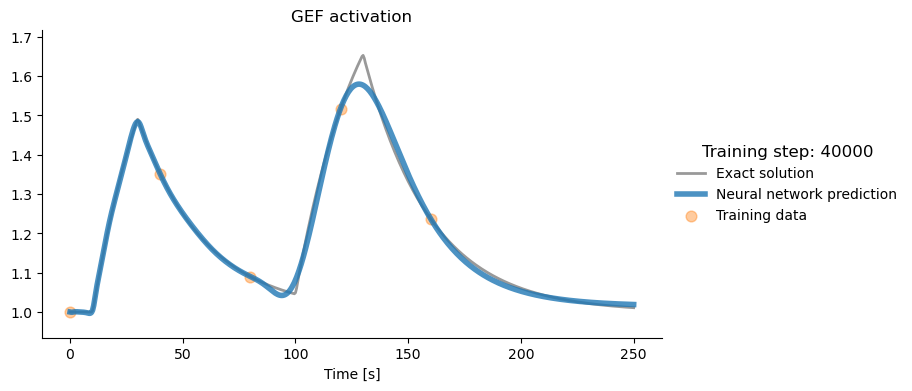

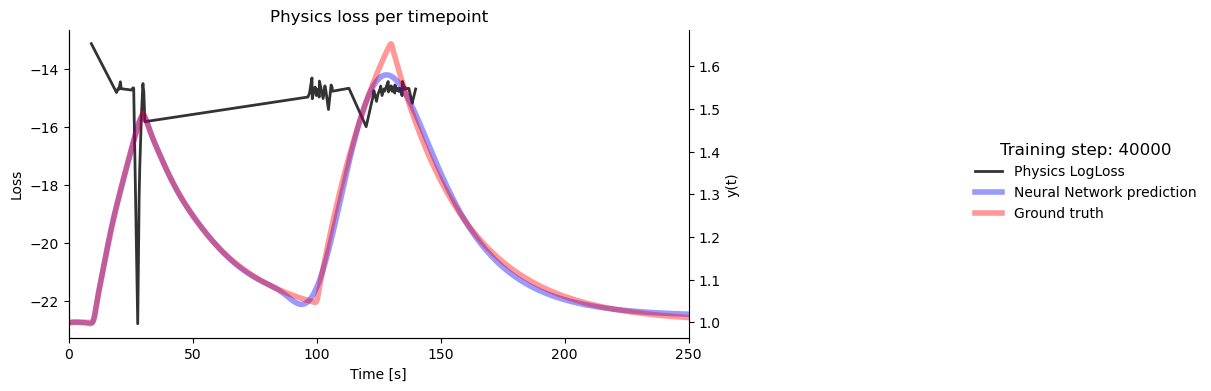

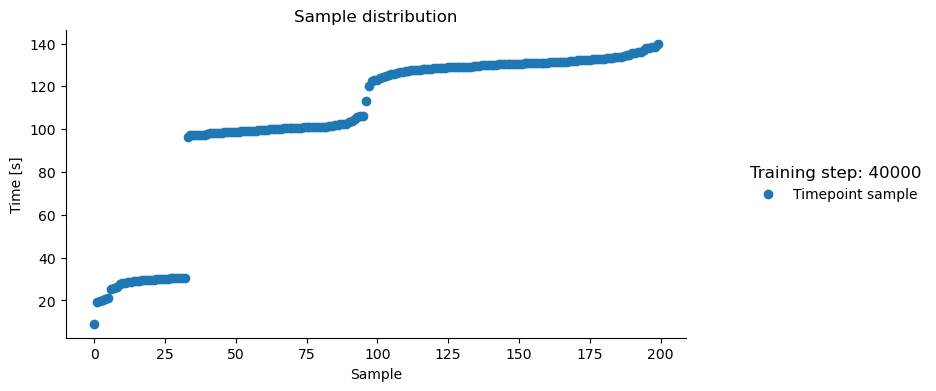

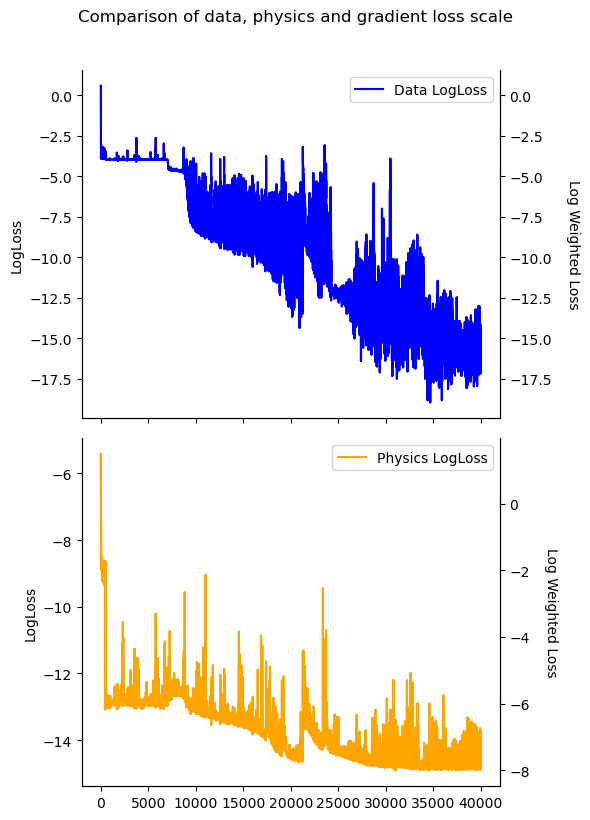

1.0000000000000002e-07
Epoch: 40500
Epoch: 41000
Epoch: 41500
Epoch: 42000
tensor(0.0004, dtype=torch.float64, grad_fn=<AddBackward0>)
0.01
[1.0000000000000002e-07]
Epoch: 42500
Epoch: 43000
1.0000000000000004e-08
Epoch: 43500
Epoch: 44000
Epoch: 44500
Epoch: 45000
tensor(0.0004, dtype=torch.float64, grad_fn=<AddBackward0>)
0.01
[1.0000000000000004e-08]


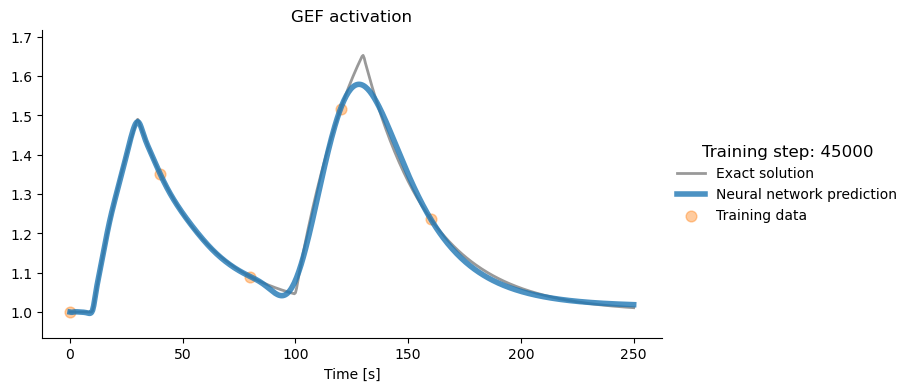

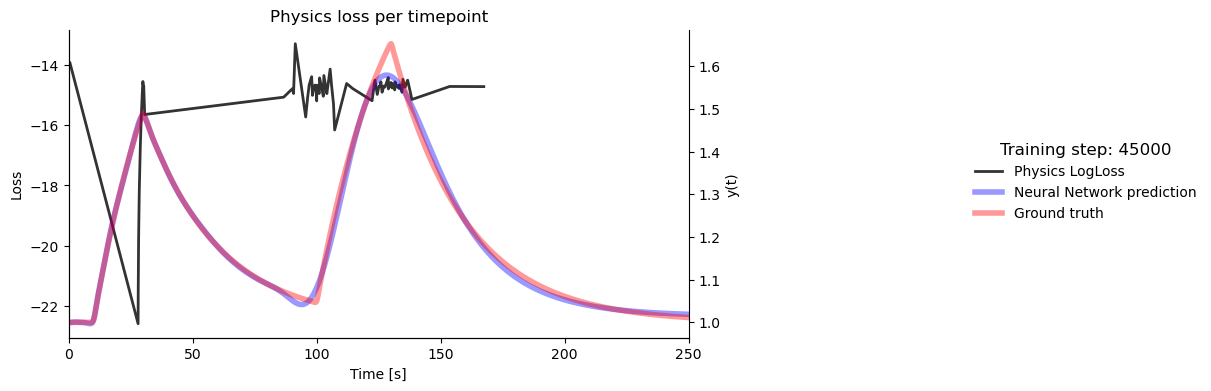

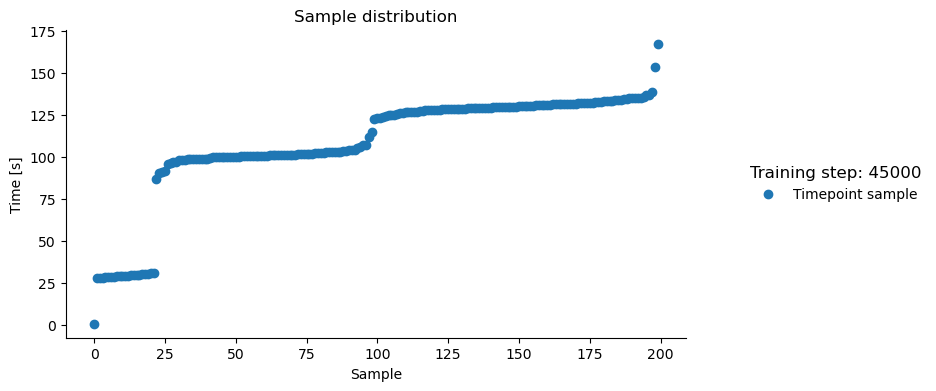

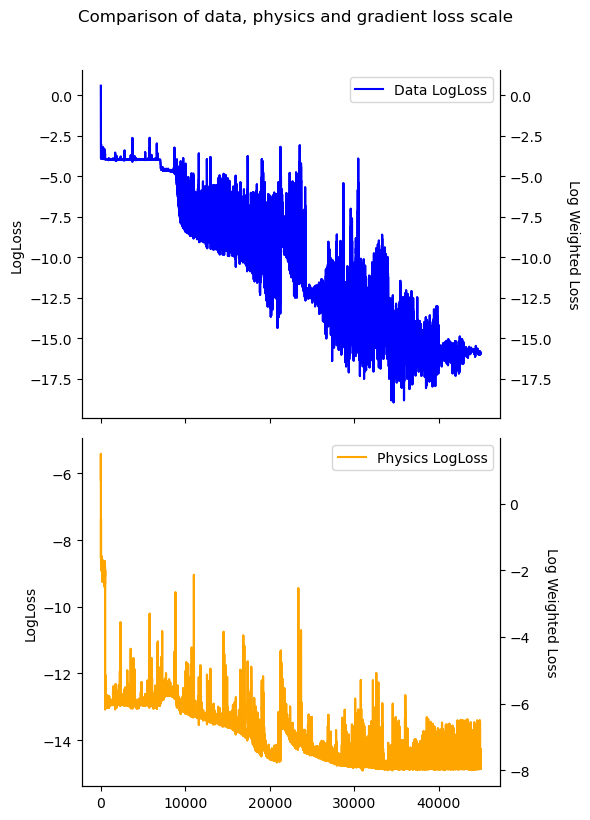

Epoch: 45500
Epoch: 46000
Epoch: 46500
Epoch: 47000
Epoch: 47500
Epoch: 48000
tensor(0.0004, dtype=torch.float64, grad_fn=<AddBackward0>)
0.01
[1.0000000000000004e-08]
Epoch: 48500
Epoch: 49000
Epoch: 49500
Epoch: 50000


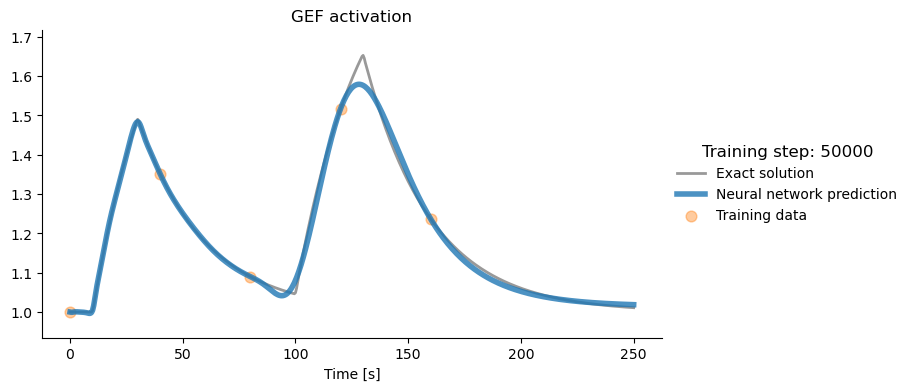

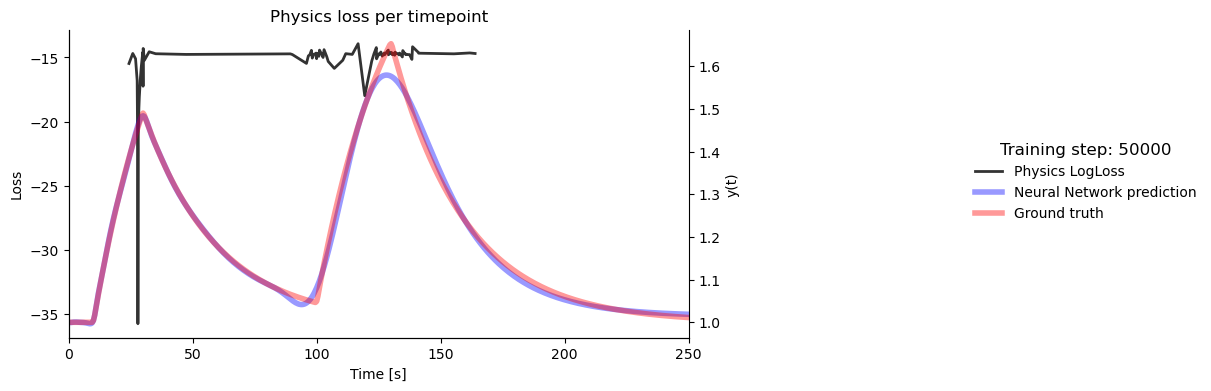

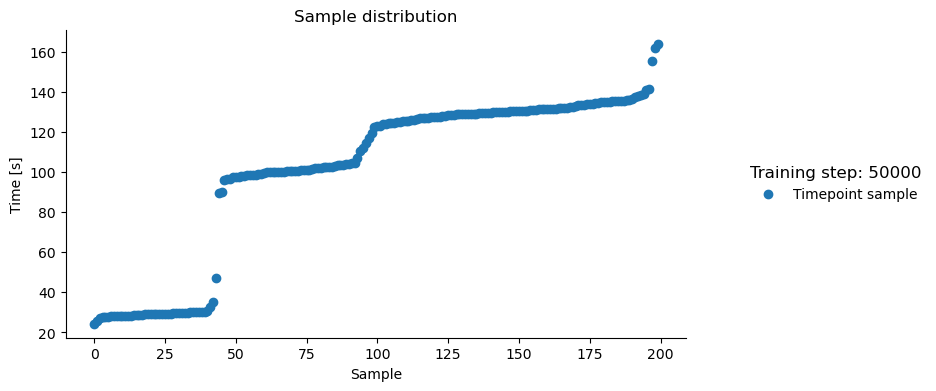

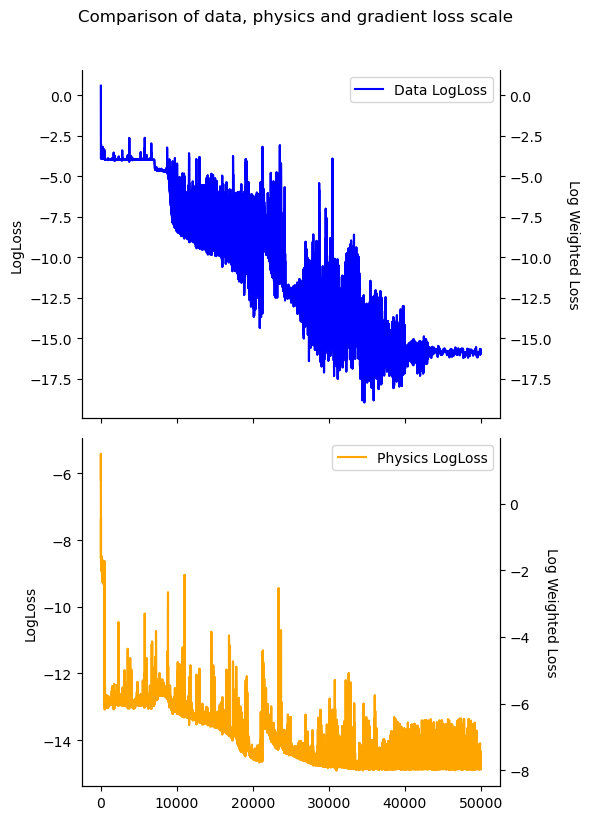

Epoch: 50500
Epoch: 51000
tensor(0.0004, dtype=torch.float64, grad_fn=<AddBackward0>)
0.01
[1.0000000000000004e-08]
Epoch: 51500
Epoch: 52000
Epoch: 52500
Epoch: 53000
Epoch: 53500
Epoch: 54000
tensor(0.0004, dtype=torch.float64, grad_fn=<AddBackward0>)
0.01
[1.0000000000000004e-08]
Epoch: 54500
Epoch: 55000


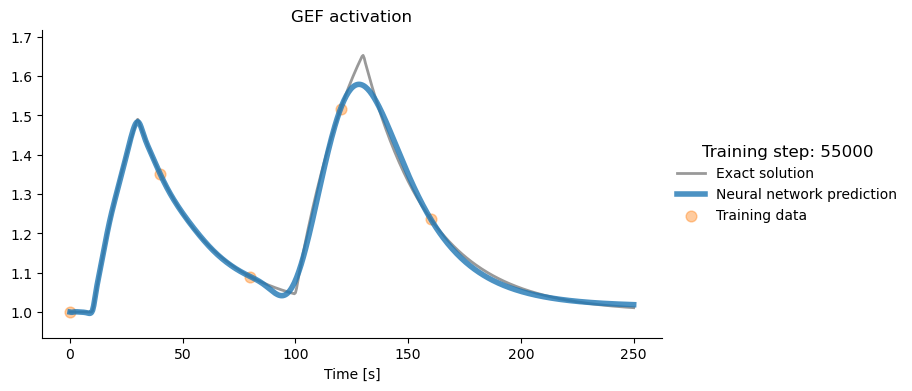

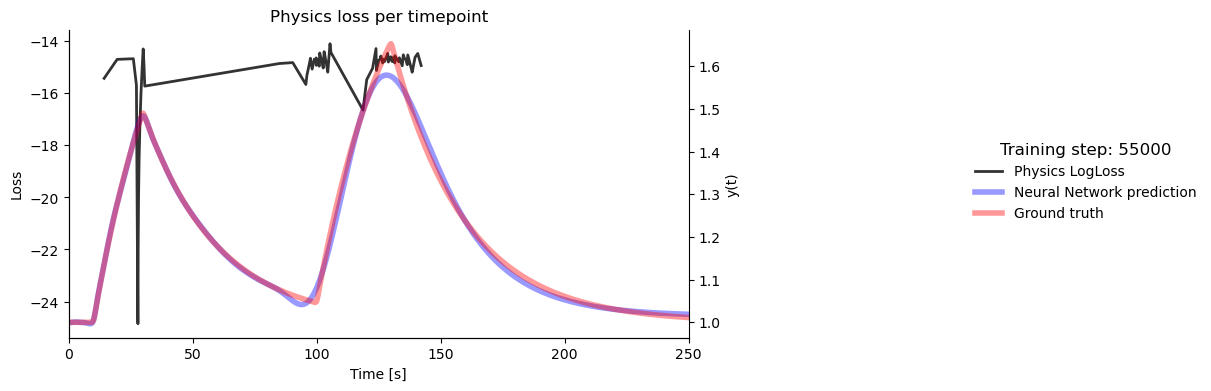

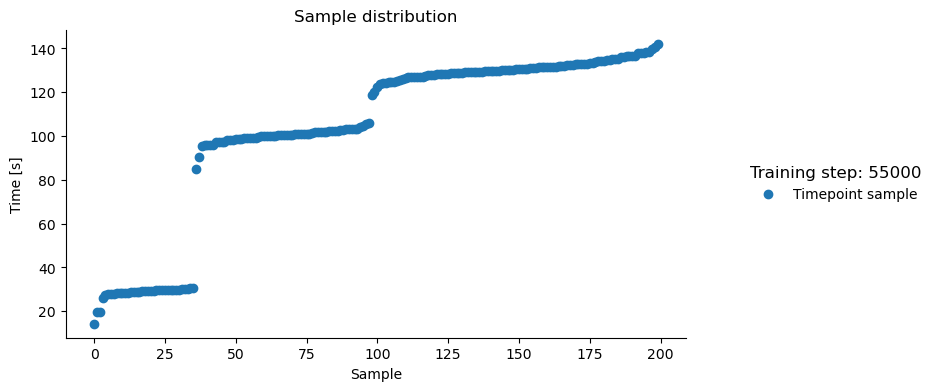

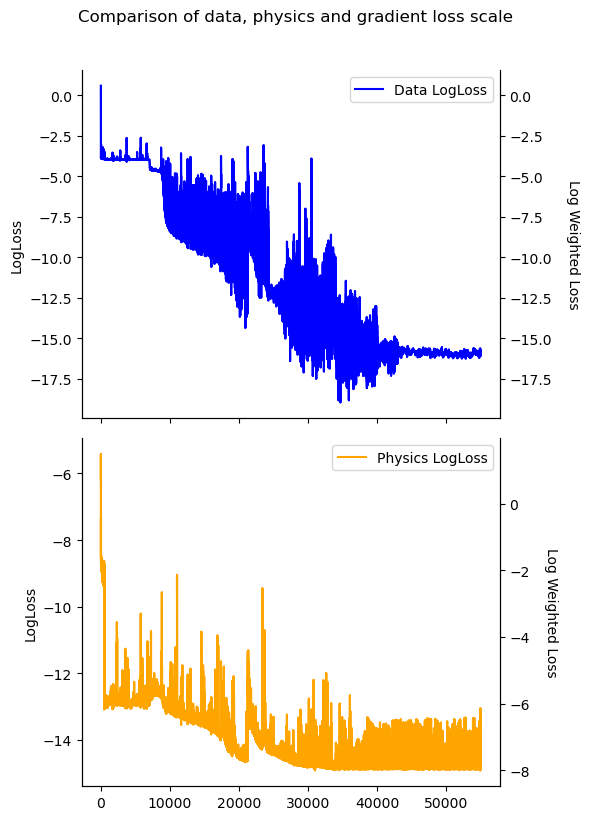

Epoch: 55500
Epoch: 56000
Epoch: 56500
Epoch: 57000
tensor(0.0004, dtype=torch.float64, grad_fn=<AddBackward0>)
0.01
[1.0000000000000004e-08]
Epoch: 57500
Epoch: 58000
Epoch: 58500
Epoch: 59000
Epoch: 59500
Epoch: 60000
tensor(0.0004, dtype=torch.float64, grad_fn=<AddBackward0>)
0.01
[1.0000000000000004e-08]


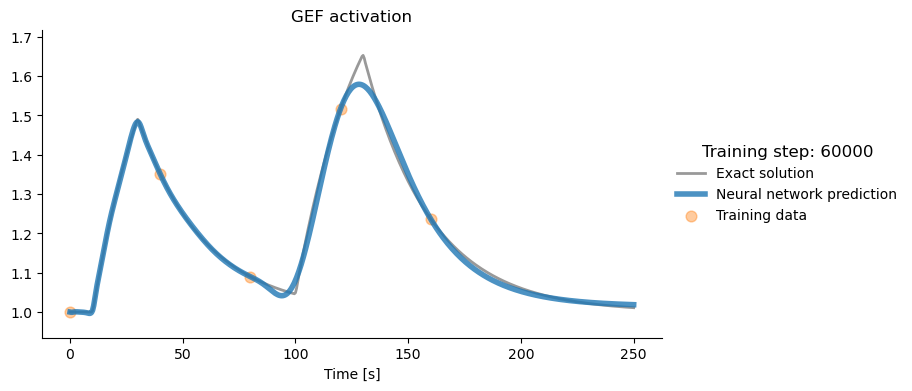

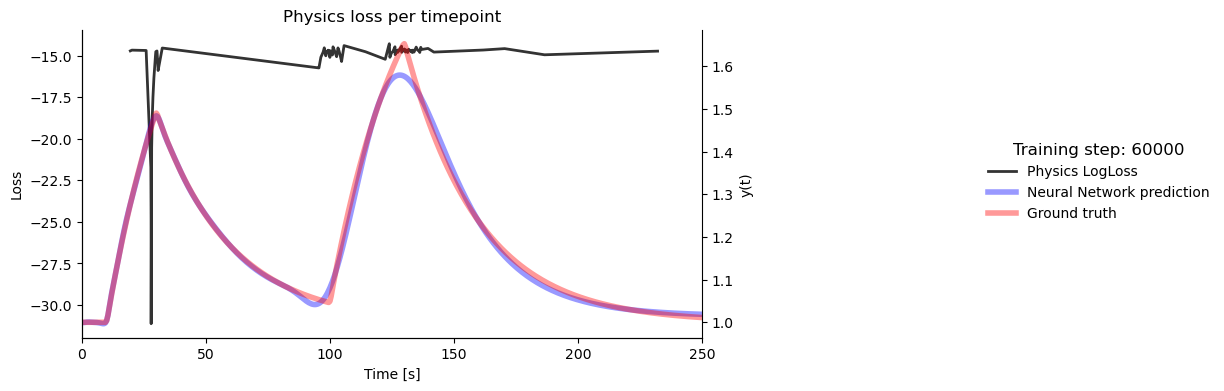

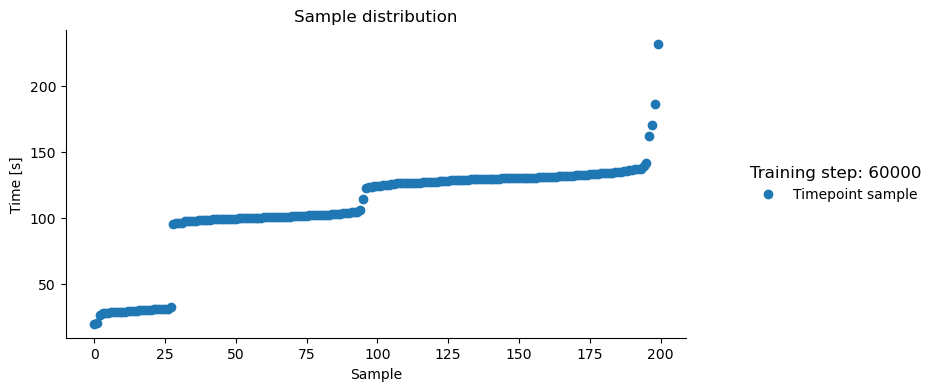

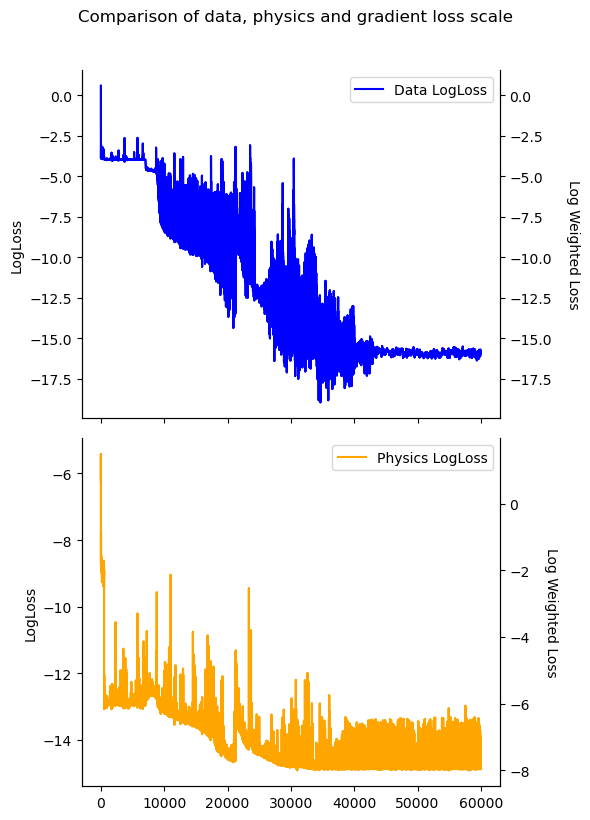

Epoch: 60500
Epoch: 61000
Epoch: 61500
Epoch: 62000
Epoch: 62500
Epoch: 63000
tensor(0.0004, dtype=torch.float64, grad_fn=<AddBackward0>)
0.01
[1.0000000000000004e-08]
Epoch: 63500
Epoch: 64000
Epoch: 64500
Epoch: 65000


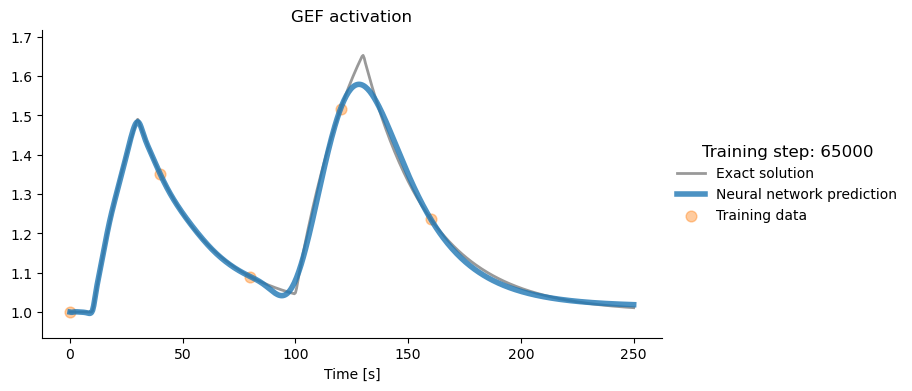

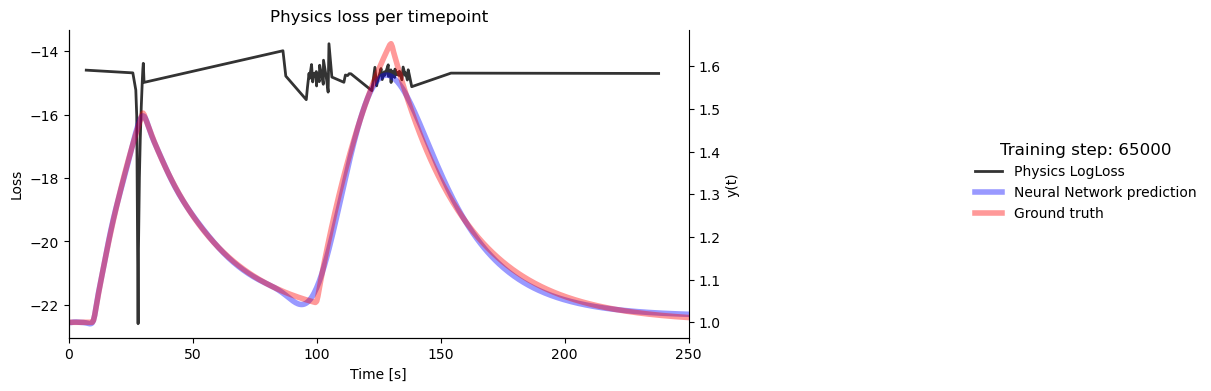

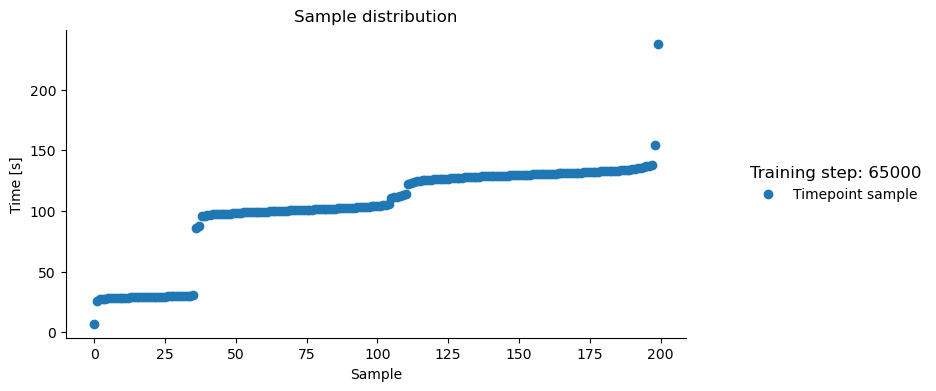

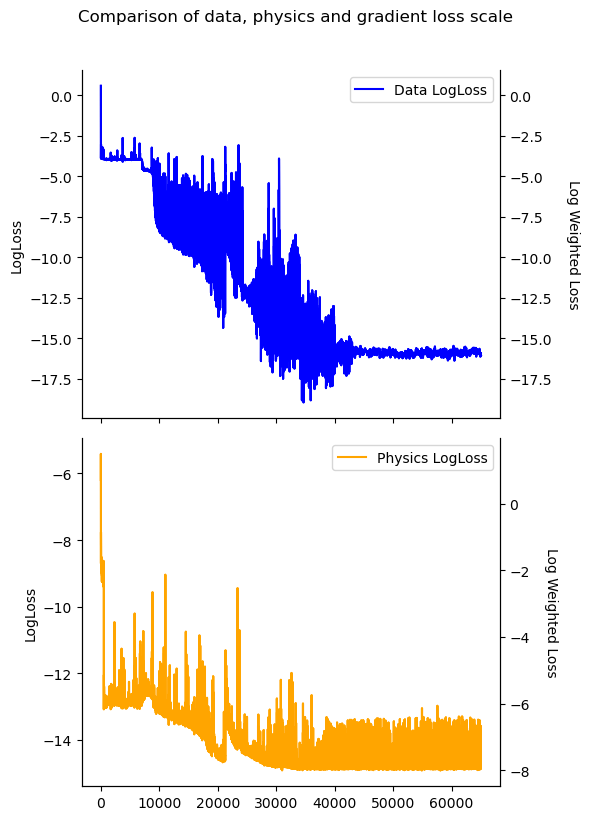

Epoch: 65500
Epoch: 66000
tensor(0.0004, dtype=torch.float64, grad_fn=<AddBackward0>)
0.01
[1.0000000000000004e-08]
Epoch: 66500
Epoch: 67000
Epoch: 67500
Epoch: 68000
Epoch: 68500
Epoch: 69000
tensor(0.0004, dtype=torch.float64, grad_fn=<AddBackward0>)
0.01
[1.0000000000000004e-08]
Epoch: 69500
Epoch: 70000


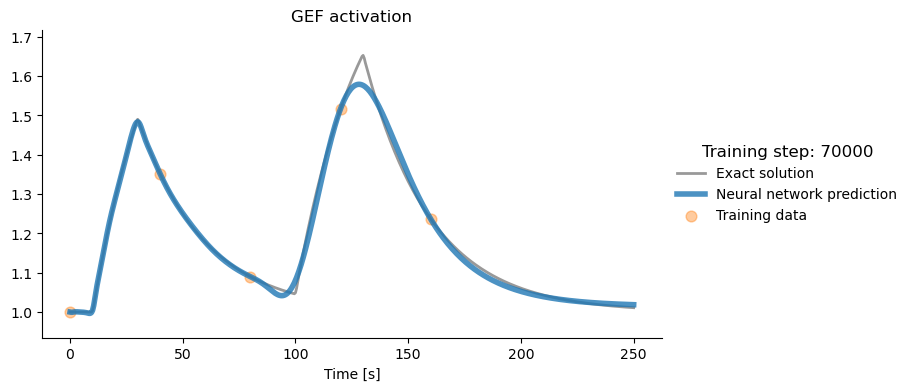

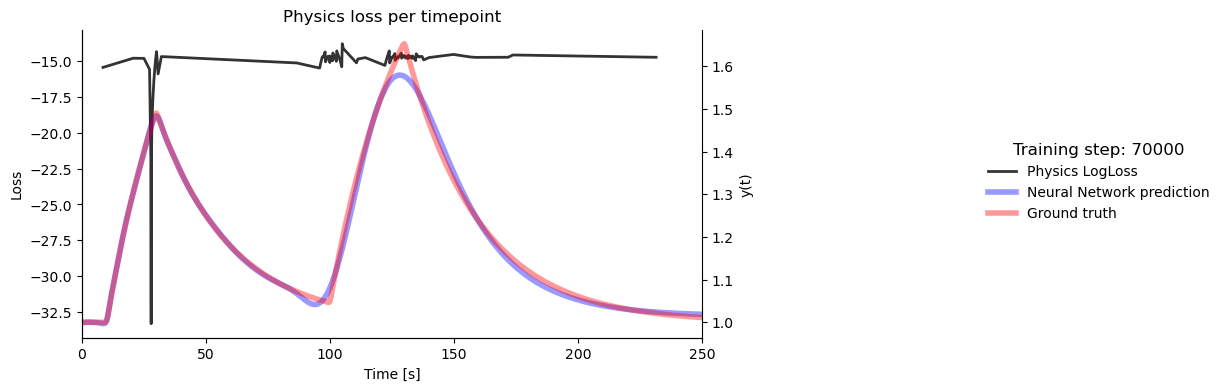

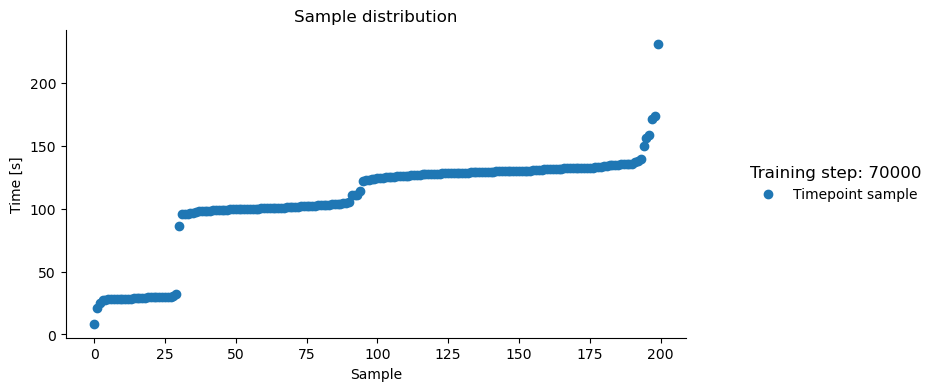

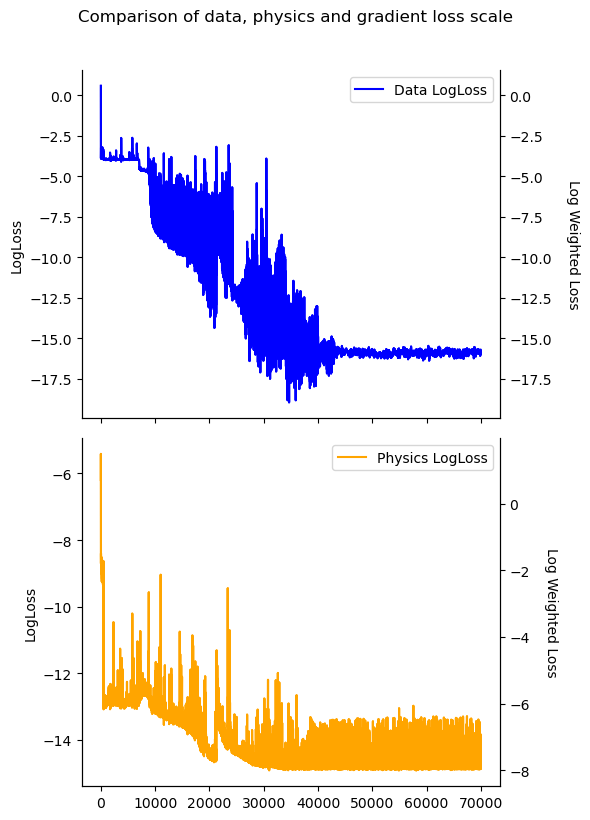

Epoch: 70500
Epoch: 71000
Epoch: 71500
Epoch: 72000
tensor(0.0004, dtype=torch.float64, grad_fn=<AddBackward0>)
0.01
[1.0000000000000004e-08]
Epoch: 72500
Epoch: 73000
Epoch: 73500
Epoch: 74000
Epoch: 74500
Epoch: 75000
tensor(0.0004, dtype=torch.float64, grad_fn=<AddBackward0>)
0.01
[1.0000000000000004e-08]


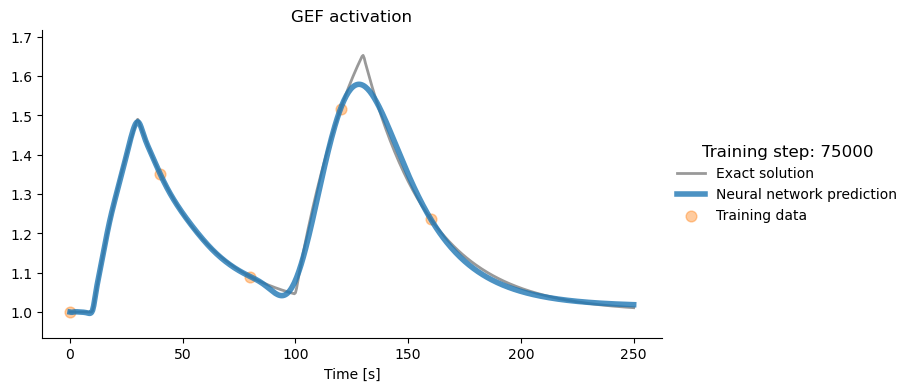

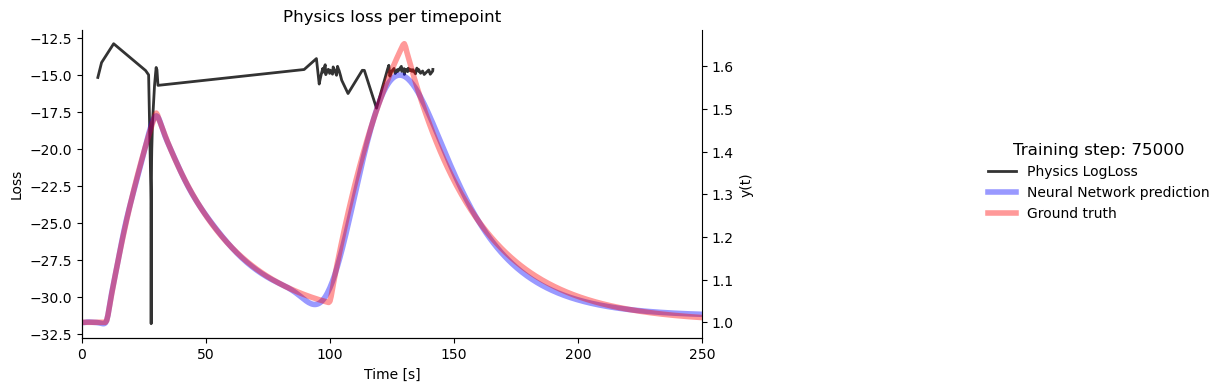

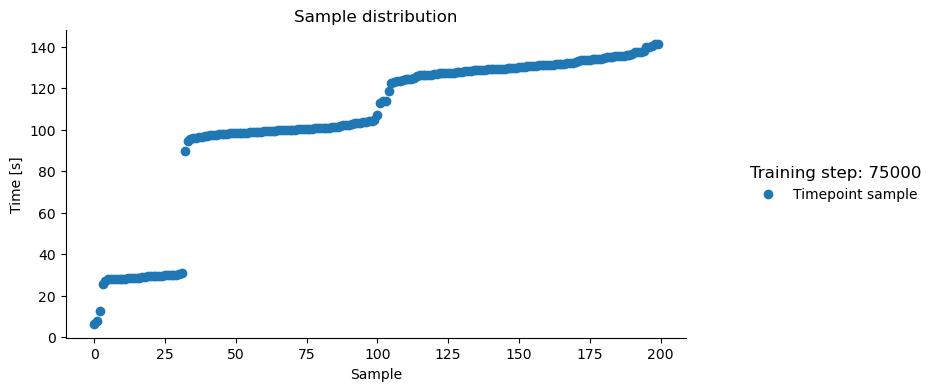

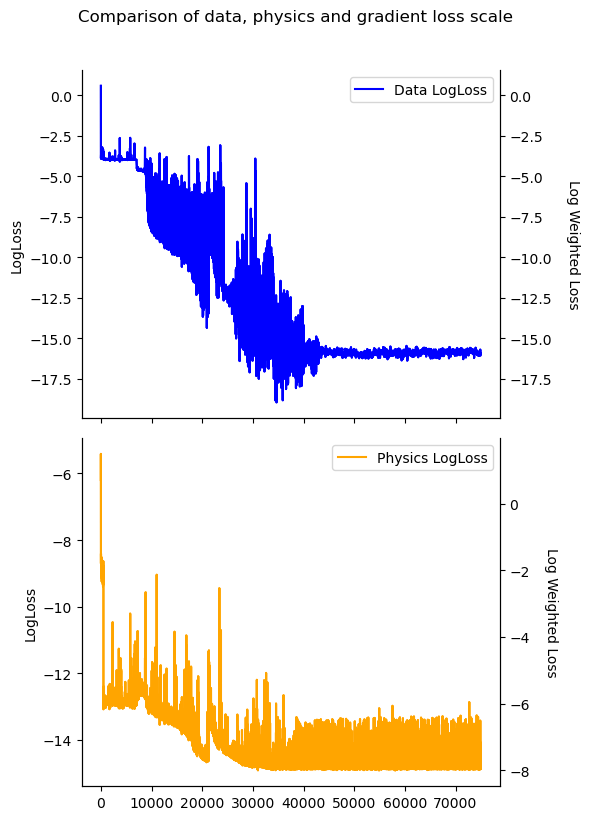

Epoch: 75500
Epoch: 76000
Epoch: 76500
Epoch: 77000
Epoch: 77500
Epoch: 78000
tensor(0.0004, dtype=torch.float64, grad_fn=<AddBackward0>)
0.01
[1.0000000000000004e-08]
Epoch: 78500
Epoch: 79000
Epoch: 79500
Epoch: 80000


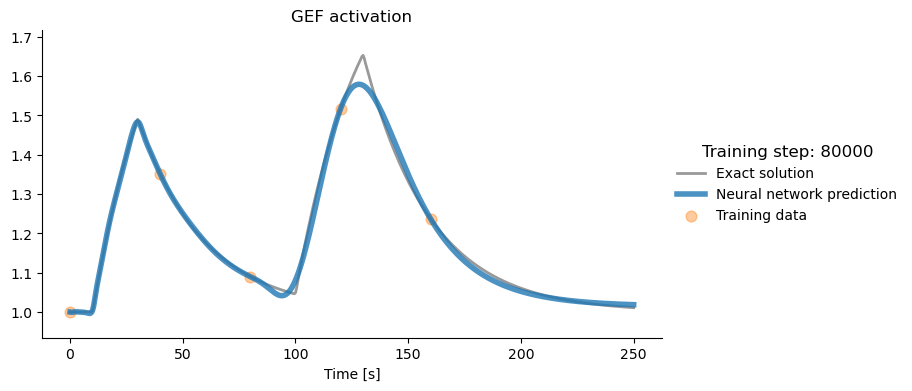

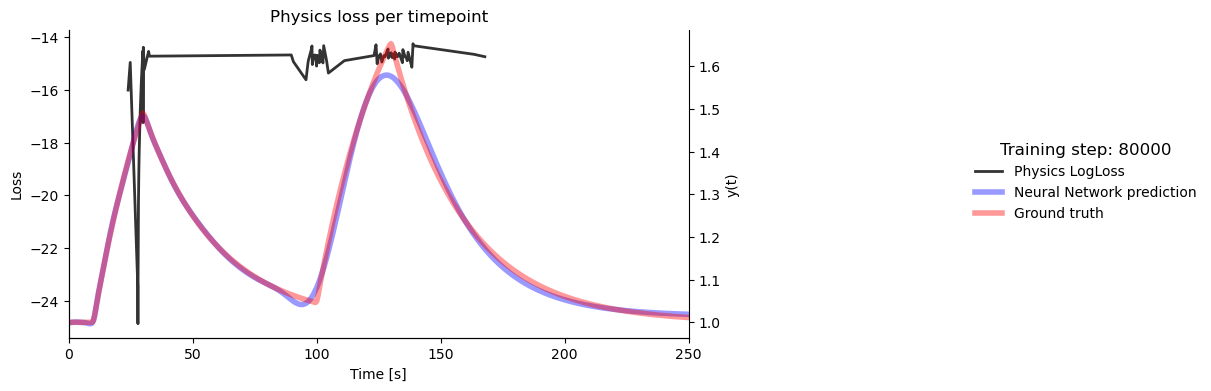

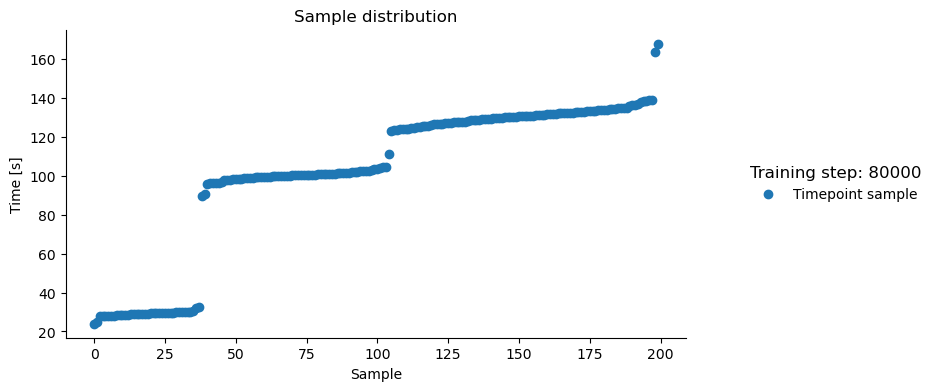

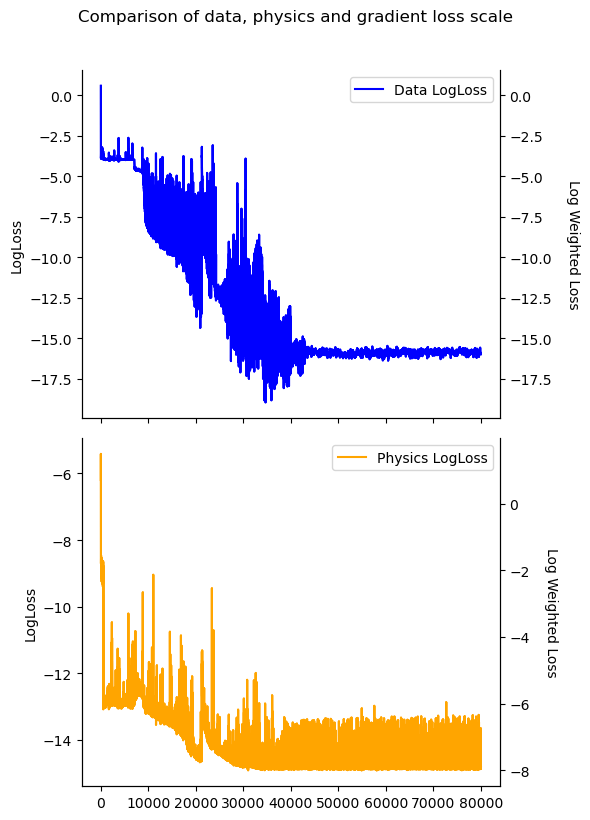

Epoch: 80500
Epoch: 81000
tensor(0.0004, dtype=torch.float64, grad_fn=<AddBackward0>)
0.01
[1.0000000000000004e-08]
Epoch: 81500
Epoch: 82000
Epoch: 82500
Epoch: 83000
Epoch: 83500
Epoch: 84000
tensor(0.0004, dtype=torch.float64, grad_fn=<AddBackward0>)
0.01
[1.0000000000000004e-08]
Epoch: 84500
Epoch: 85000


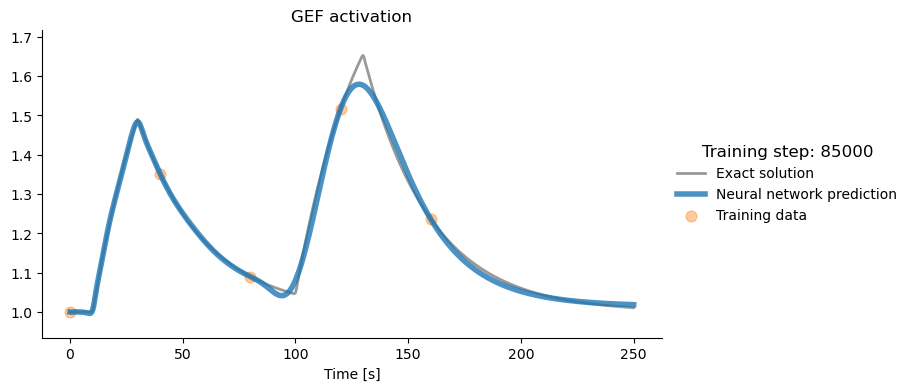

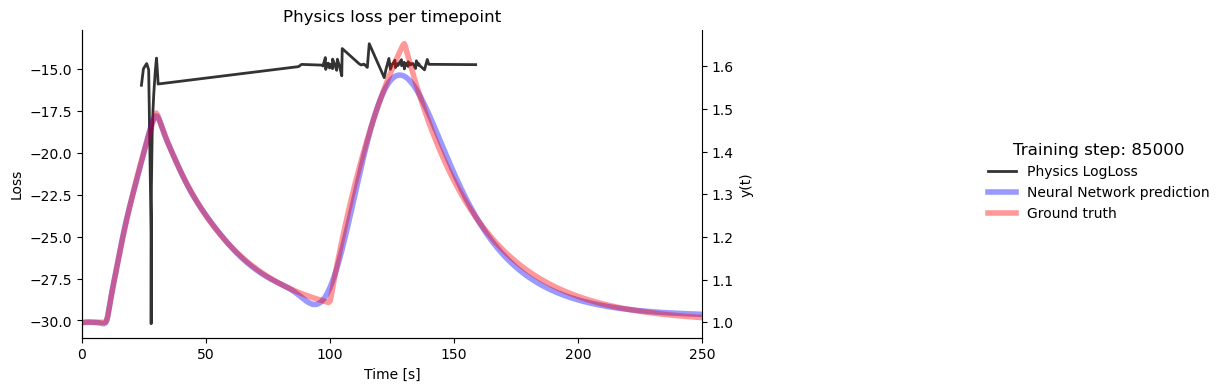

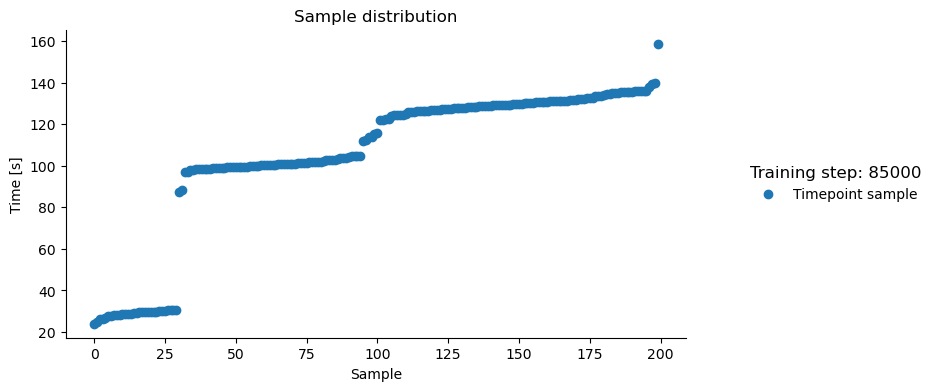

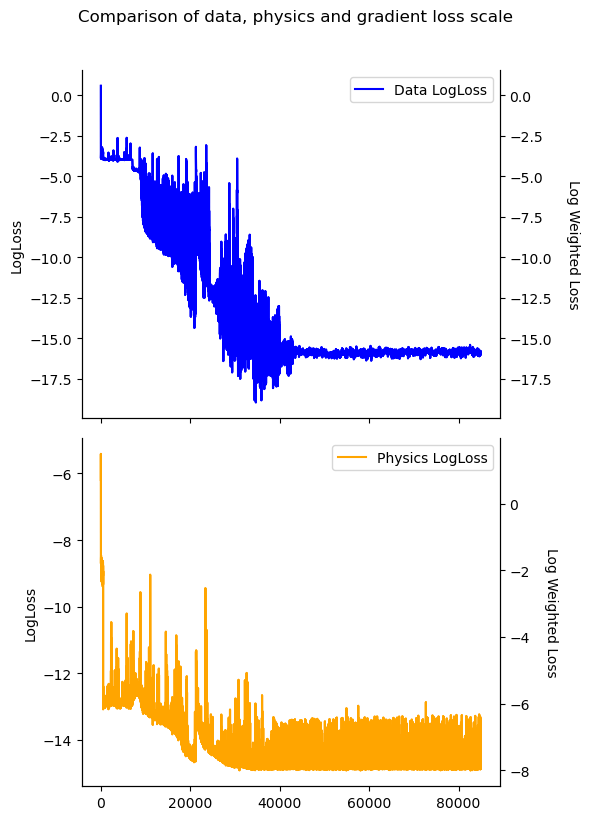

Epoch: 85500
Epoch: 86000
Epoch: 86500
Epoch: 87000
tensor(0.0004, dtype=torch.float64, grad_fn=<AddBackward0>)
0.01
[1.0000000000000004e-08]
Epoch: 87500
Epoch: 88000
Epoch: 88500
Epoch: 89000
Epoch: 89500
Epoch: 90000
tensor(0.0004, dtype=torch.float64, grad_fn=<AddBackward0>)
0.01
[1.0000000000000004e-08]


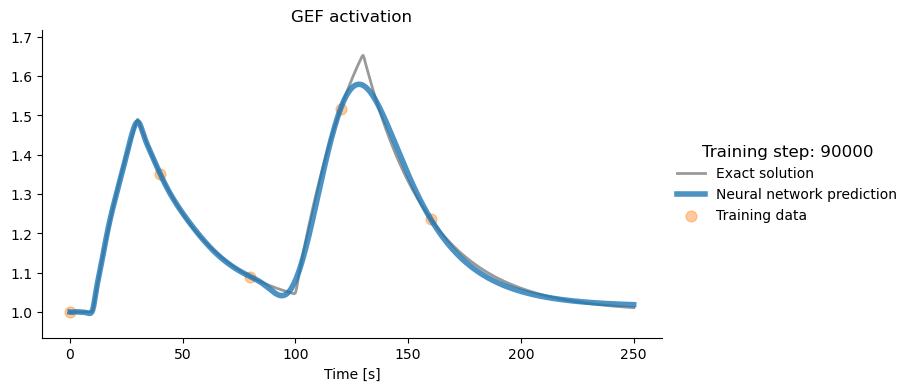

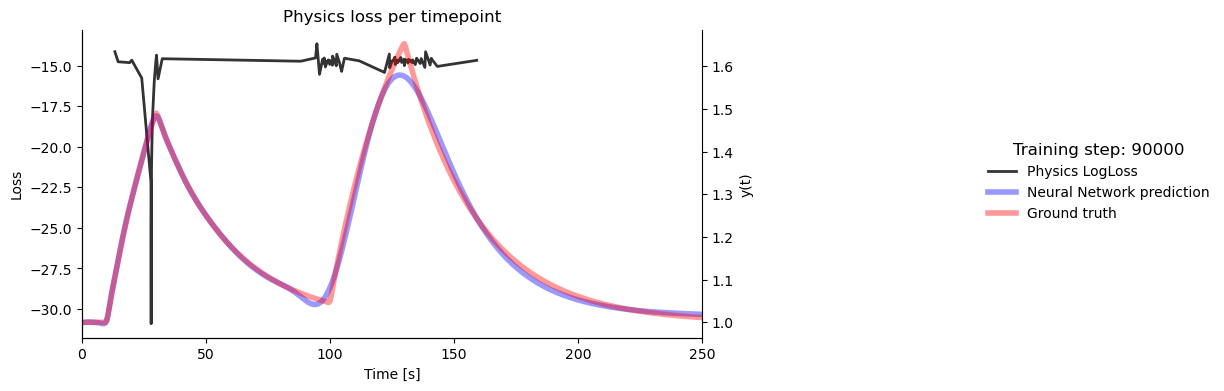

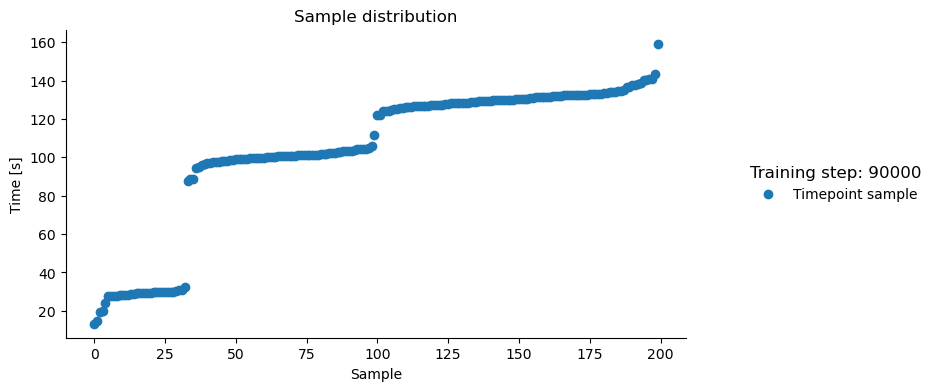

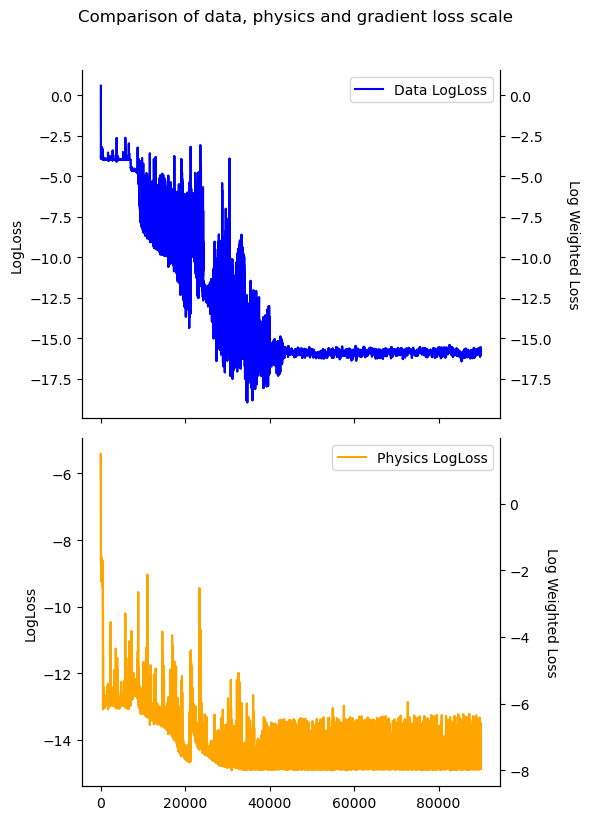

Epoch: 90500
Epoch: 91000
Epoch: 91500
Epoch: 92000
Epoch: 92500
Epoch: 93000
tensor(0.0004, dtype=torch.float64, grad_fn=<AddBackward0>)
0.01
[1.0000000000000004e-08]
Epoch: 93500
Epoch: 94000
Epoch: 94500
Epoch: 95000


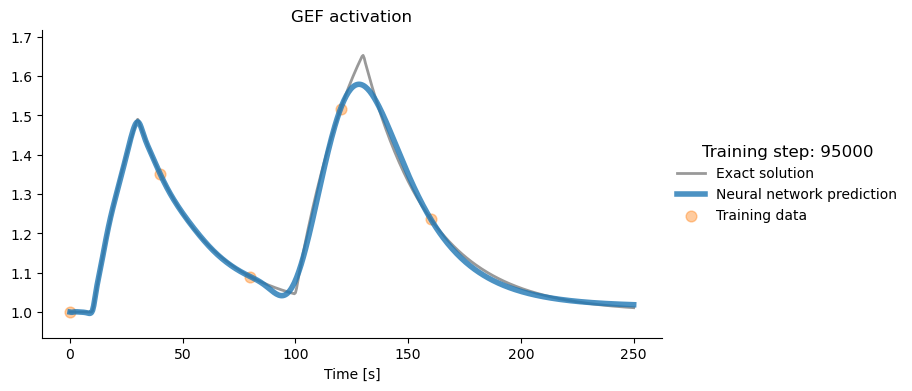

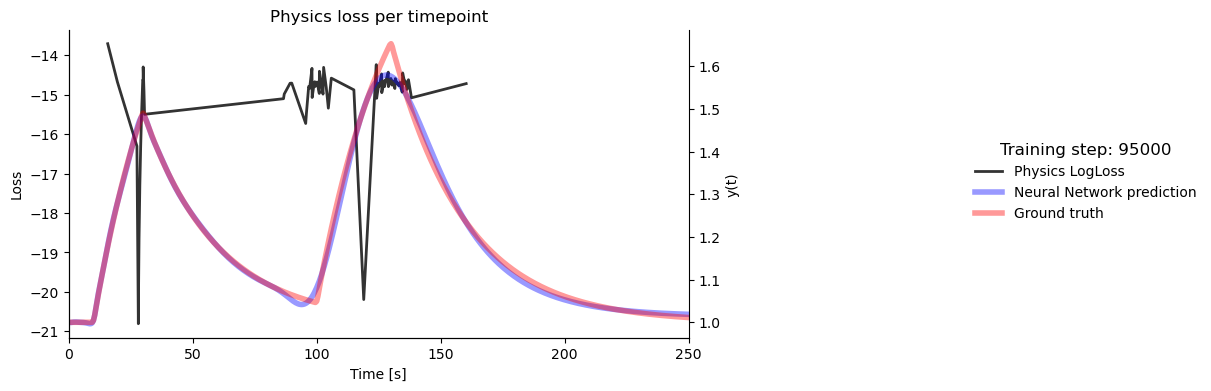

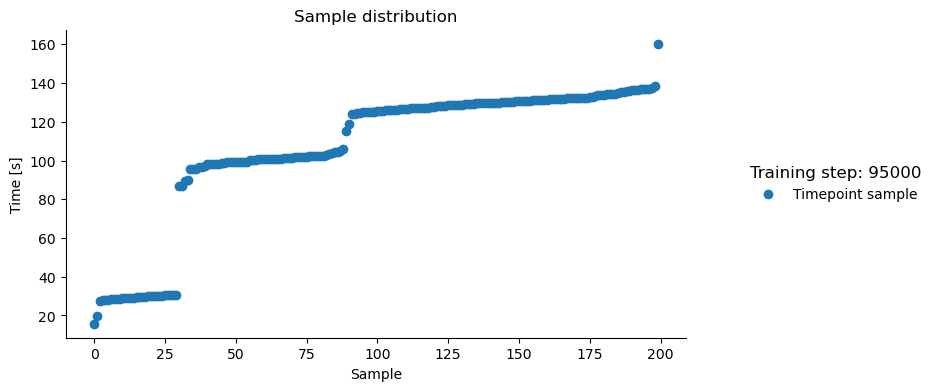

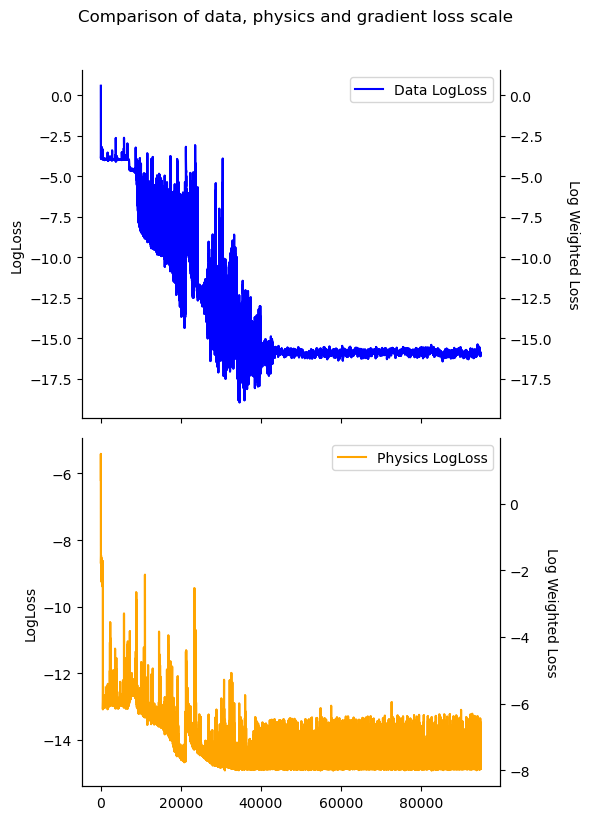

Epoch: 95500
Epoch: 96000
tensor(0.0004, dtype=torch.float64, grad_fn=<AddBackward0>)
0.01
[1.0000000000000004e-08]
Epoch: 96500
Epoch: 97000
Epoch: 97500
Epoch: 98000
Epoch: 98500
Epoch: 99000
tensor(0.0004, dtype=torch.float64, grad_fn=<AddBackward0>)
0.01
[1.0000000000000004e-08]
Epoch: 99500
Epoch: 100000


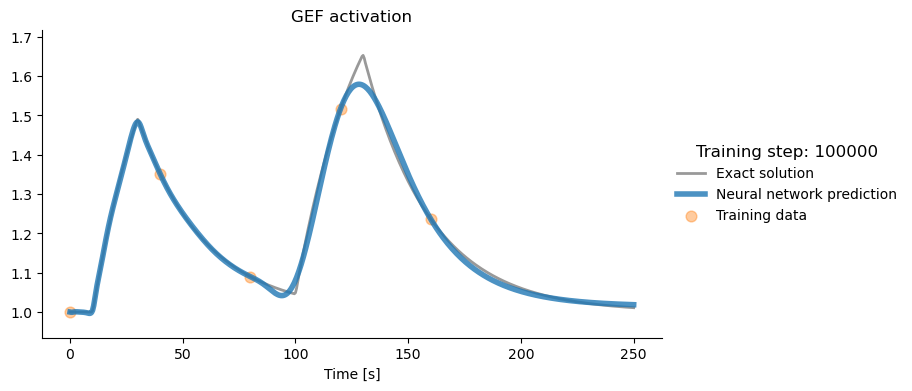

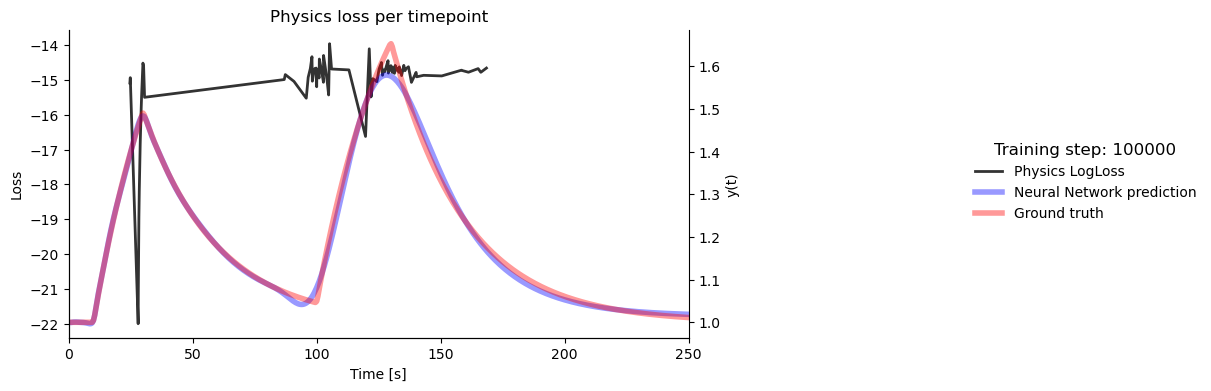

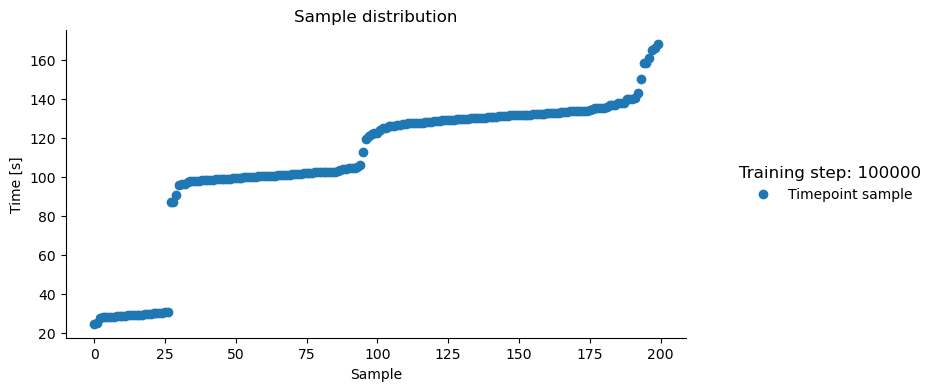

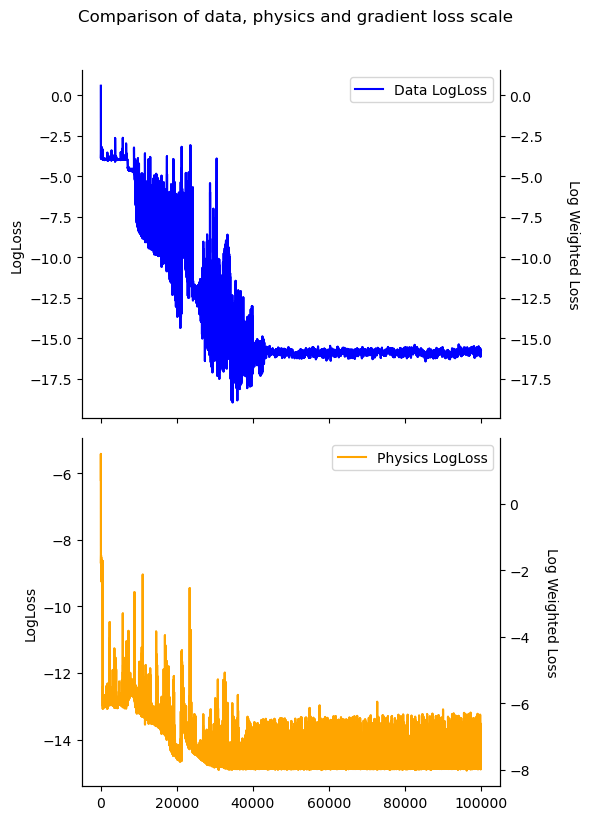

Epoch: 100500
Epoch: 101000
Epoch: 101500
Epoch: 102000
tensor(0.0004, dtype=torch.float64, grad_fn=<AddBackward0>)
0.01
[1.0000000000000004e-08]
Epoch: 102500
Epoch: 103000
Epoch: 103500
Epoch: 104000
Epoch: 104500
Epoch: 105000
tensor(0.0004, dtype=torch.float64, grad_fn=<AddBackward0>)
0.01
[1.0000000000000004e-08]


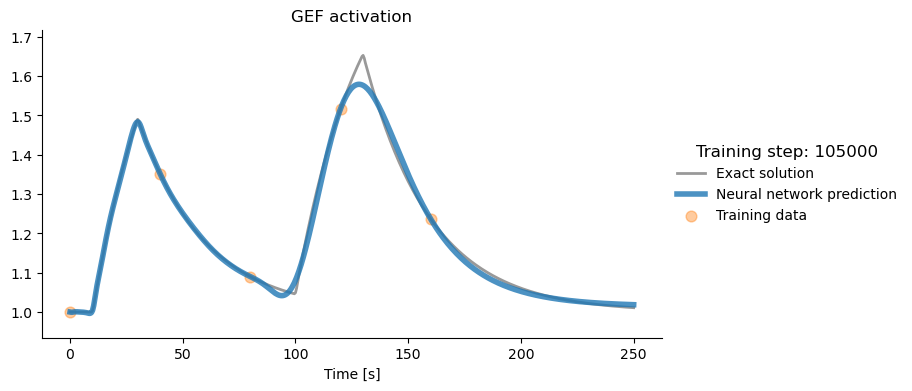

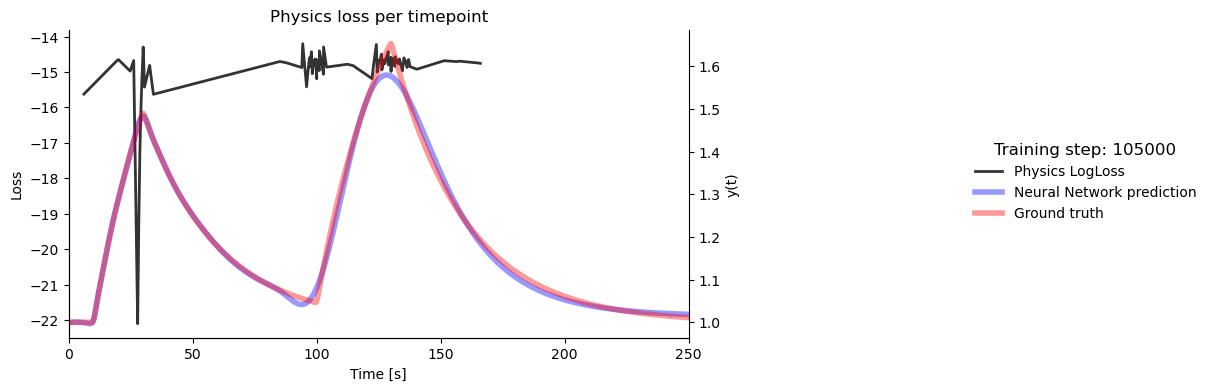

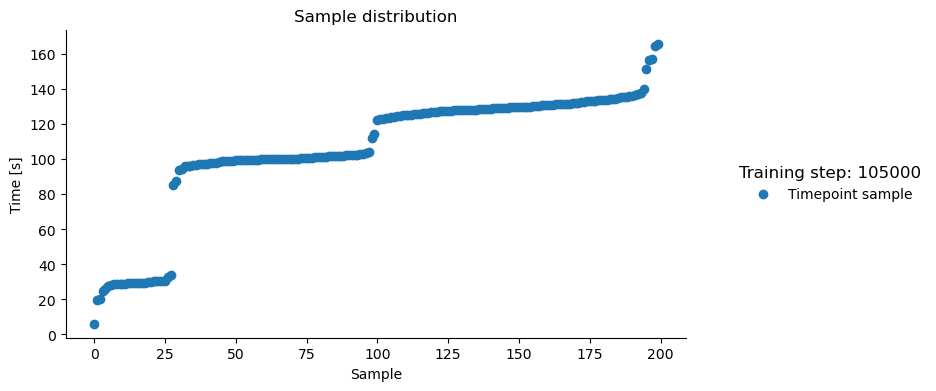

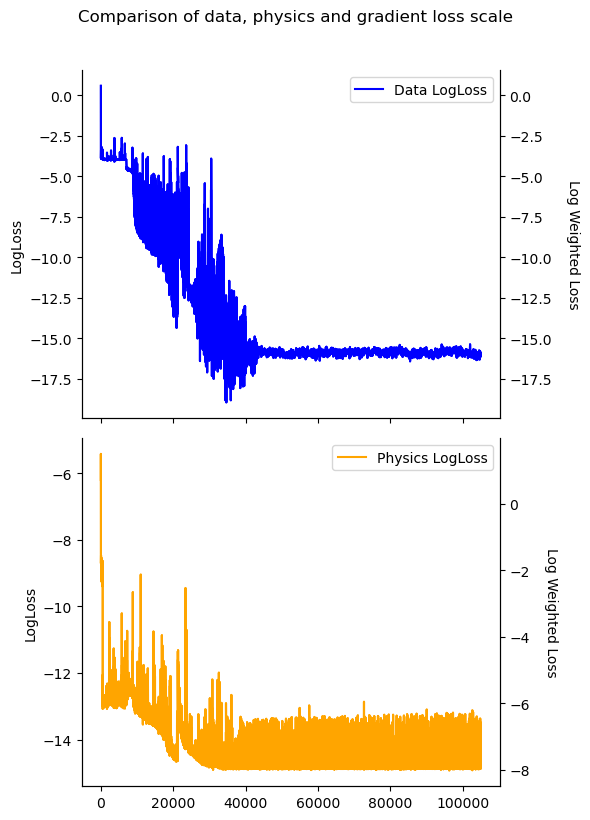

Epoch: 105500
Epoch: 106000
Epoch: 106500
Epoch: 107000
Epoch: 107500
Epoch: 108000
tensor(0.0012, dtype=torch.float64, grad_fn=<AddBackward0>)
0.01
[1.0000000000000004e-08]
Epoch: 108500
Epoch: 109000
Epoch: 109500
Epoch: 110000


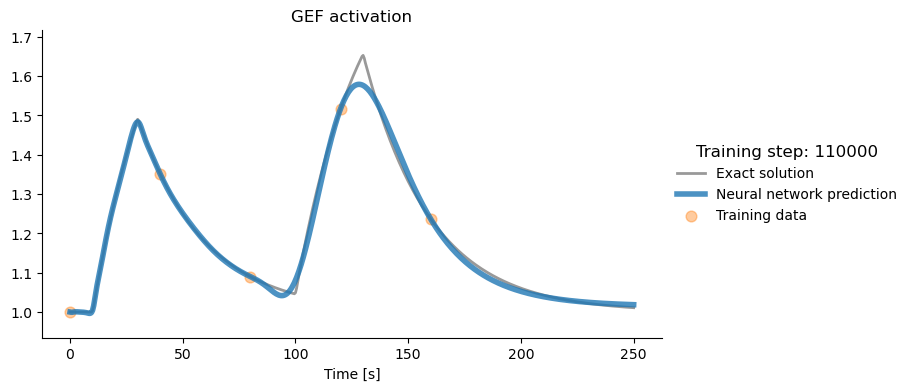

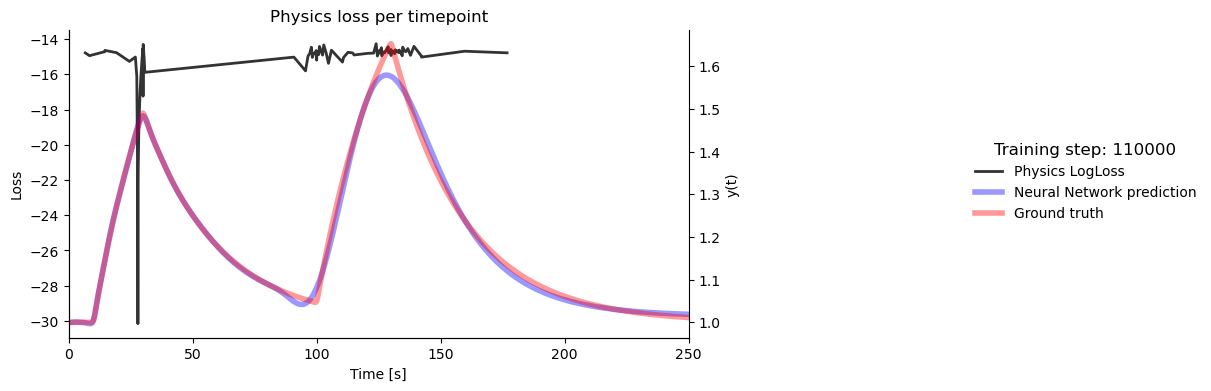

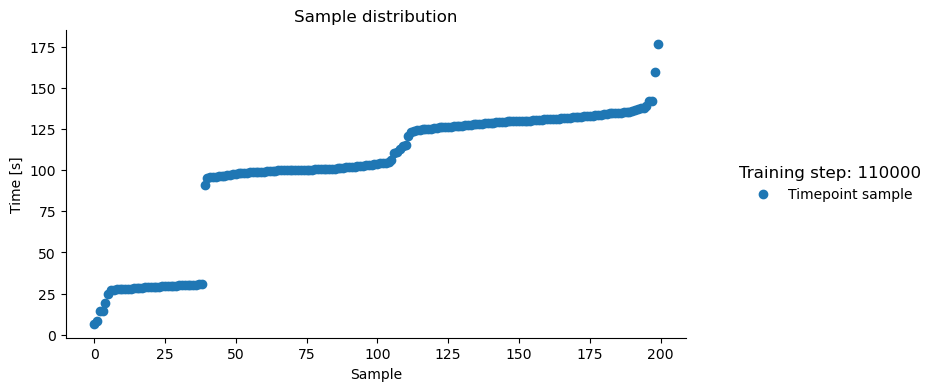

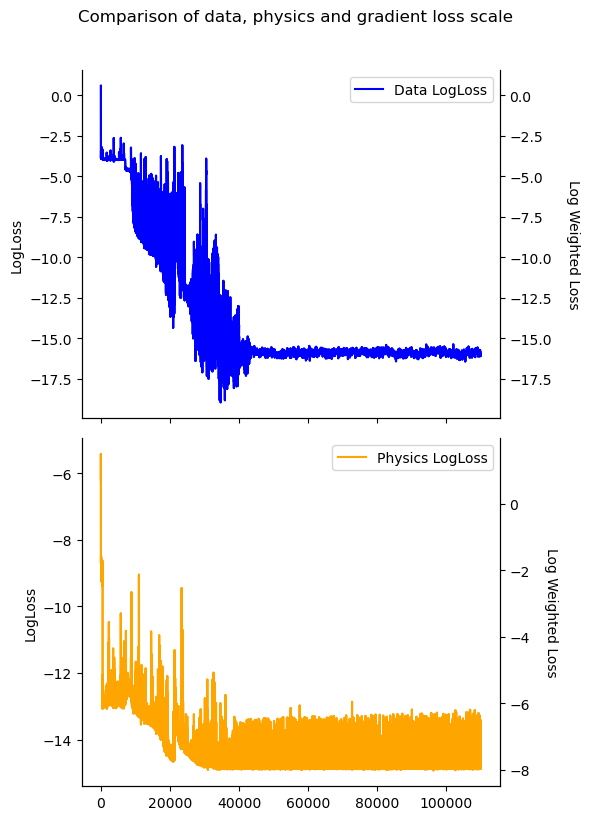

Epoch: 110500
Epoch: 111000
tensor(0.0004, dtype=torch.float64, grad_fn=<AddBackward0>)
0.01
[1.0000000000000004e-08]
Epoch: 111500
Epoch: 112000
Epoch: 112500
Epoch: 113000
Epoch: 113500
Epoch: 114000
tensor(0.0004, dtype=torch.float64, grad_fn=<AddBackward0>)
0.01
[1.0000000000000004e-08]
Epoch: 114500
Epoch: 115000


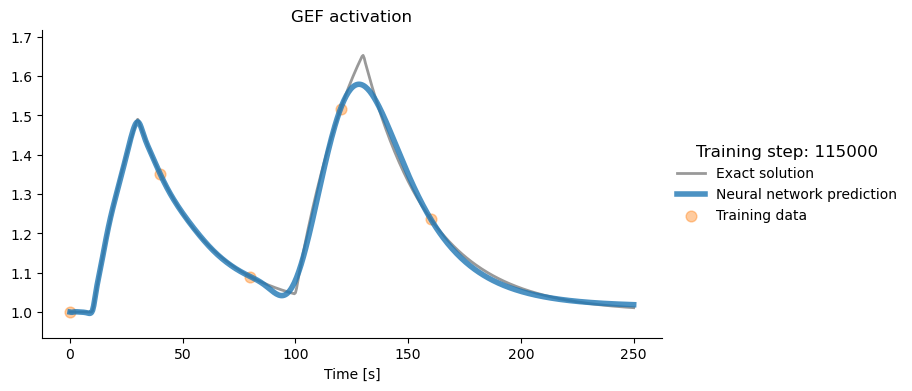

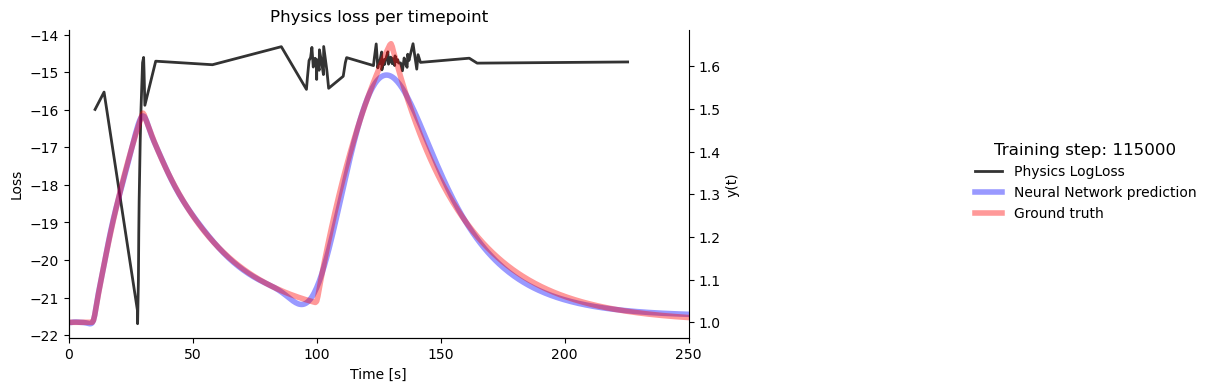

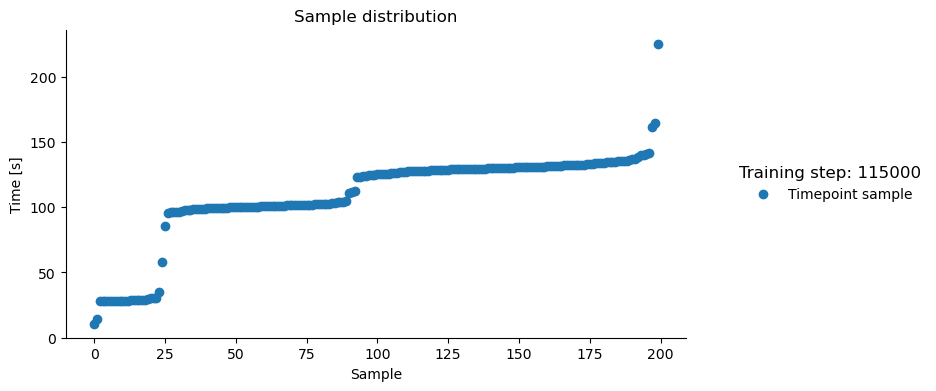

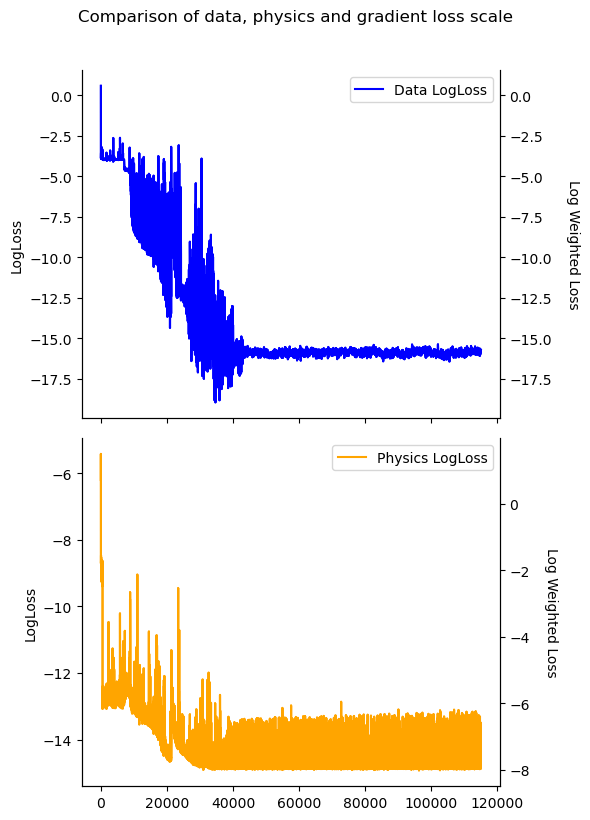

Epoch: 115500
Epoch: 116000
Epoch: 116500
Epoch: 117000
tensor(0.0004, dtype=torch.float64, grad_fn=<AddBackward0>)
0.01
[1.0000000000000004e-08]
Epoch: 117500
Epoch: 118000
Epoch: 118500
Epoch: 119000
Epoch: 119500
Epoch: 120000
tensor(0.0004, dtype=torch.float64, grad_fn=<AddBackward0>)
0.01
[1.0000000000000004e-08]


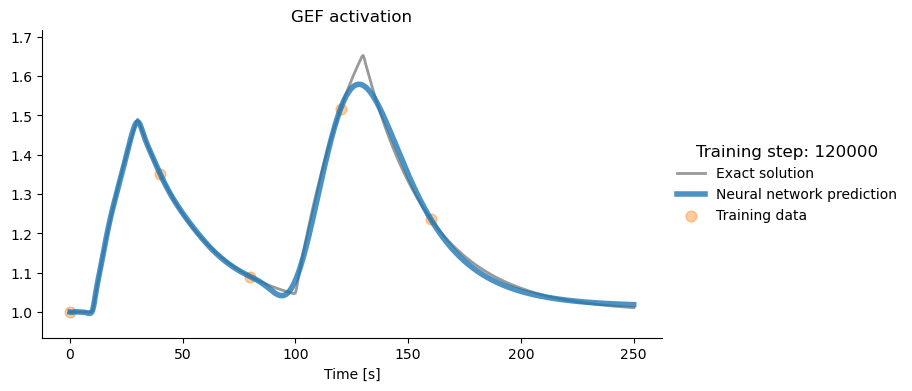

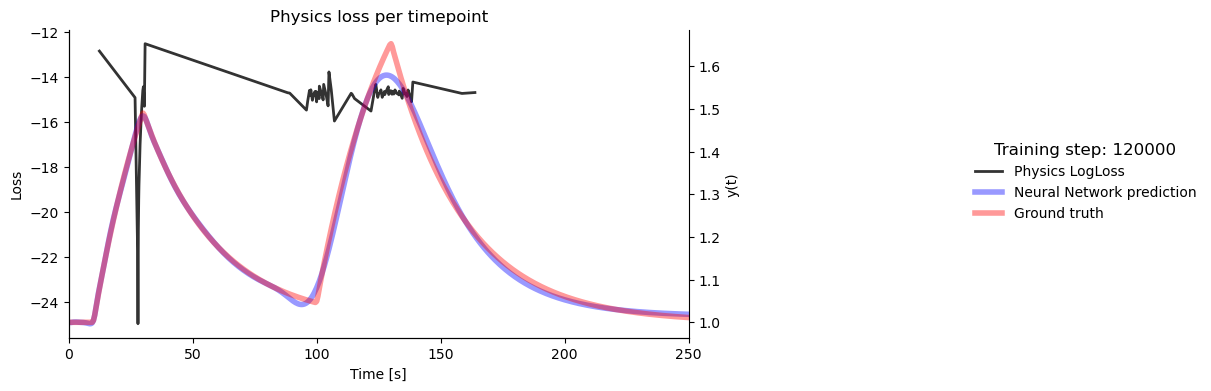

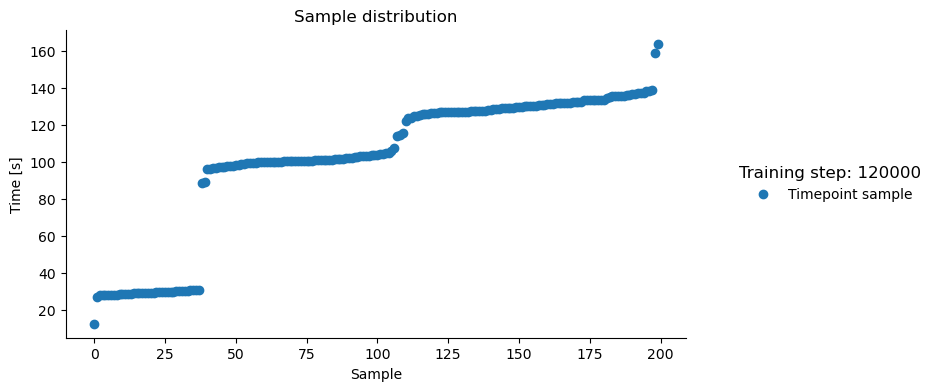

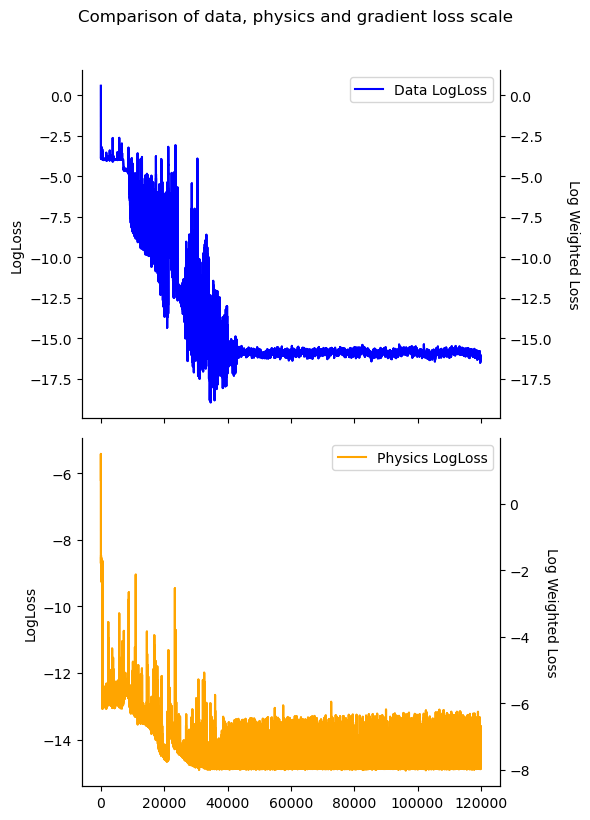

Epoch: 120500
Epoch: 121000
Epoch: 121500
Epoch: 122000
Epoch: 122500
Epoch: 123000
tensor(0.0004, dtype=torch.float64, grad_fn=<AddBackward0>)
0.01
[1.0000000000000004e-08]
Epoch: 123500
Epoch: 124000
Epoch: 124500
Epoch: 125000


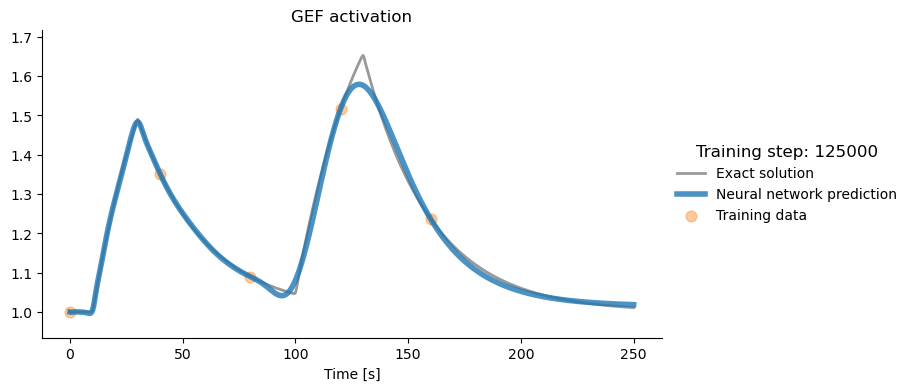

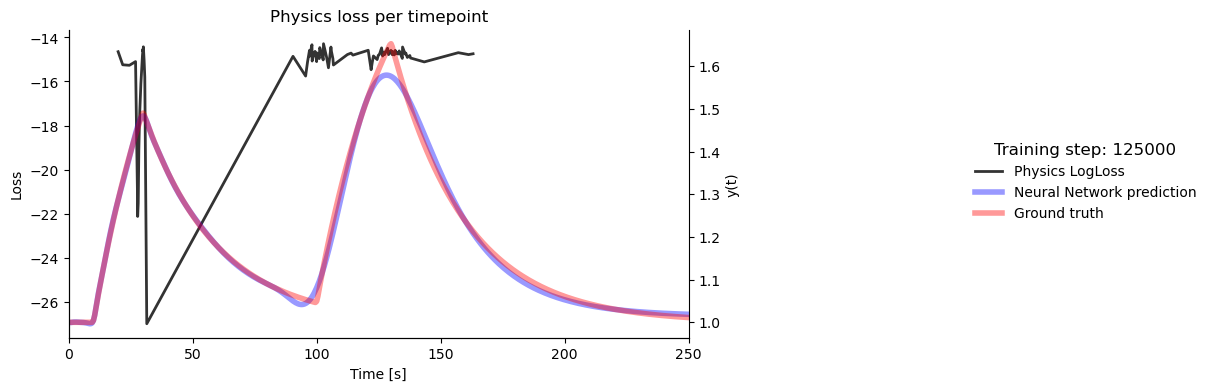

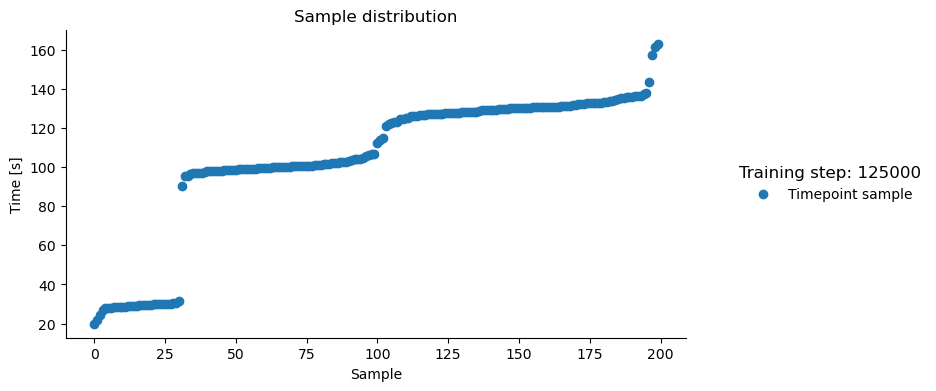

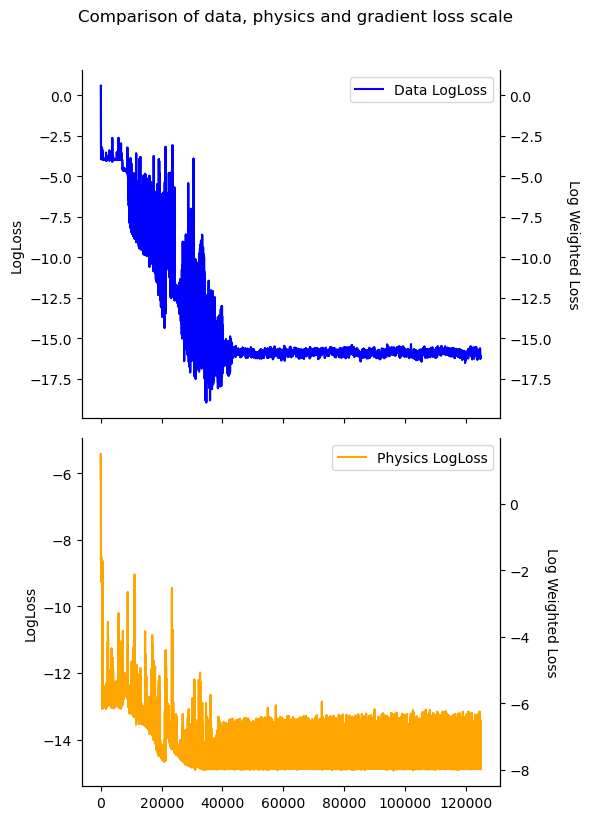

Epoch: 125500
Epoch: 126000
tensor(0.0004, dtype=torch.float64, grad_fn=<AddBackward0>)
0.01
[1.0000000000000004e-08]
Epoch: 126500
Epoch: 127000
Epoch: 127500
Epoch: 128000
Epoch: 128500
Epoch: 129000
tensor(0.0004, dtype=torch.float64, grad_fn=<AddBackward0>)
0.01
[1.0000000000000004e-08]
Epoch: 129500
Epoch: 130000


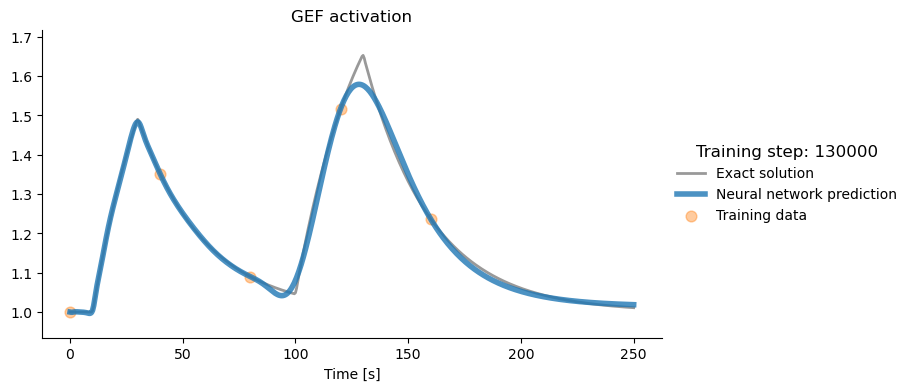

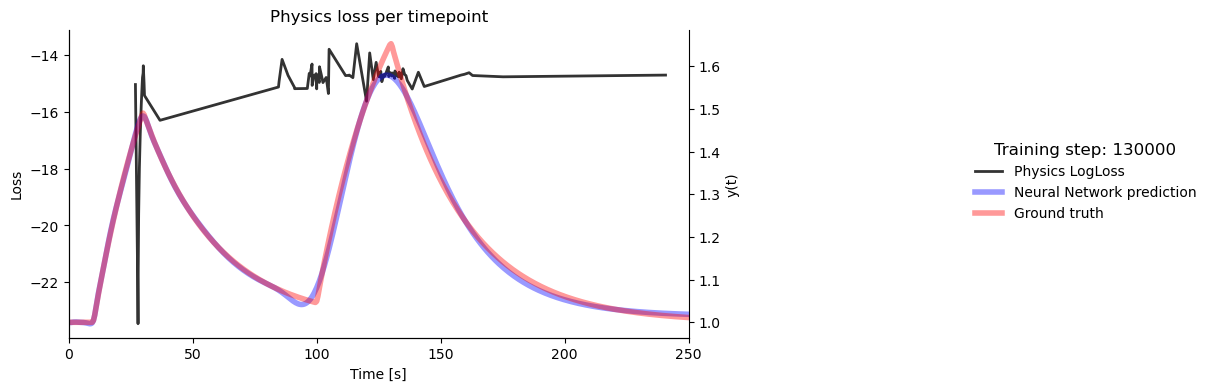

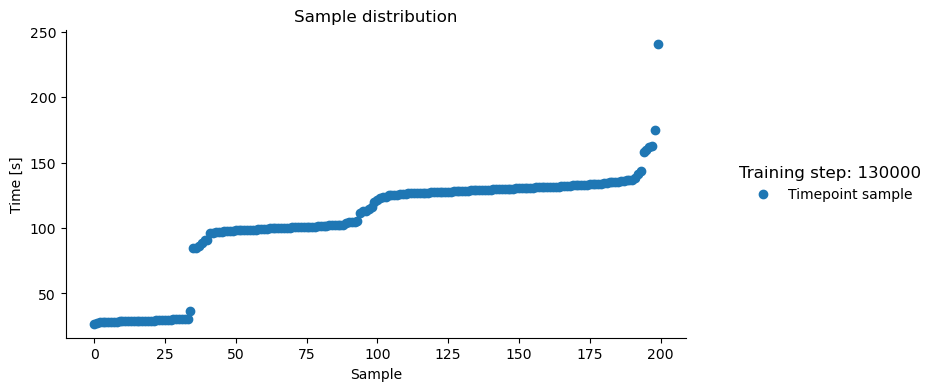

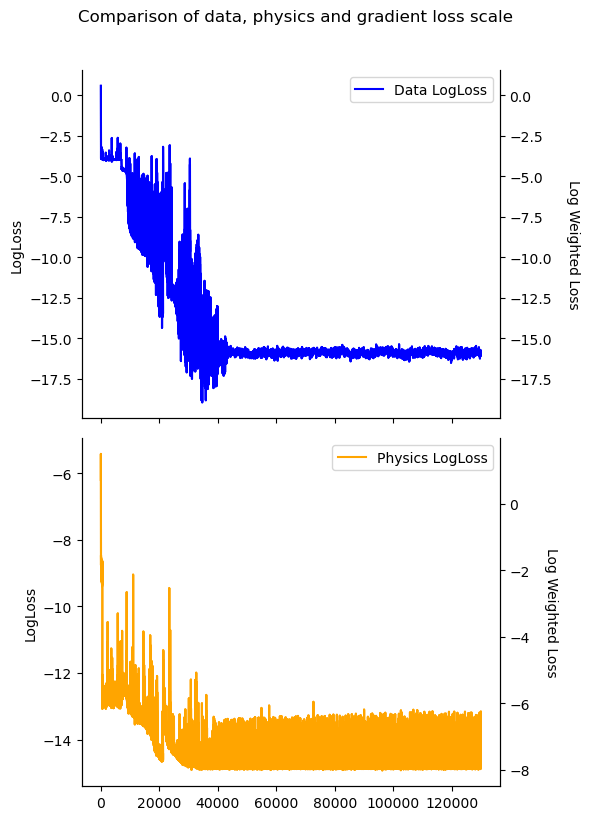

Epoch: 130500
Epoch: 131000
Epoch: 131500
Epoch: 132000
tensor(0.0004, dtype=torch.float64, grad_fn=<AddBackward0>)
0.01
[1.0000000000000004e-08]
Epoch: 132500
Epoch: 133000
Epoch: 133500
Epoch: 134000
Epoch: 134500
Epoch: 135000
tensor(0.0004, dtype=torch.float64, grad_fn=<AddBackward0>)
0.01
[1.0000000000000004e-08]


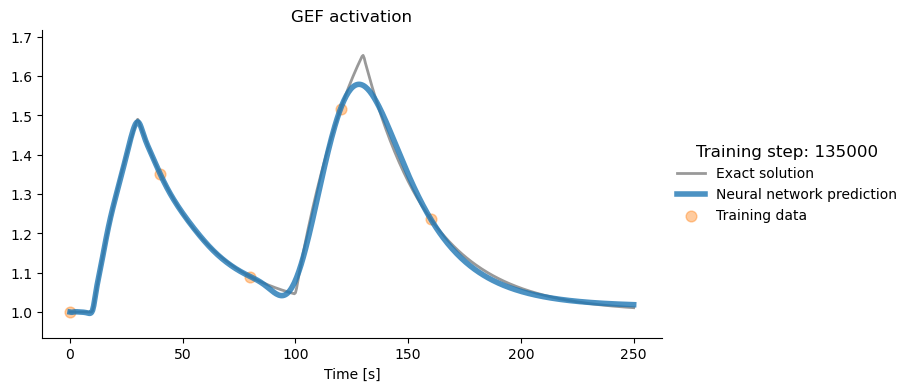

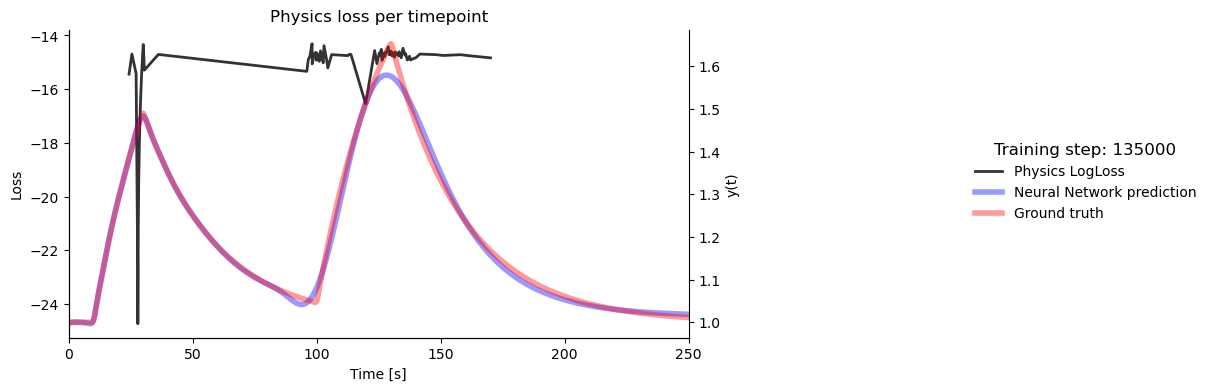

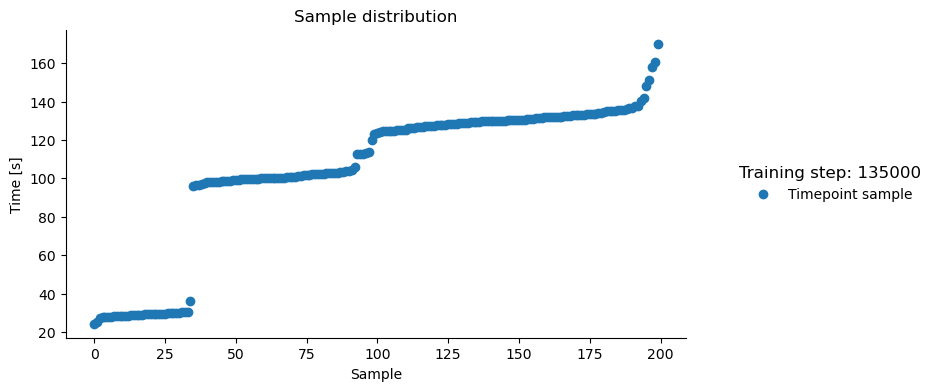

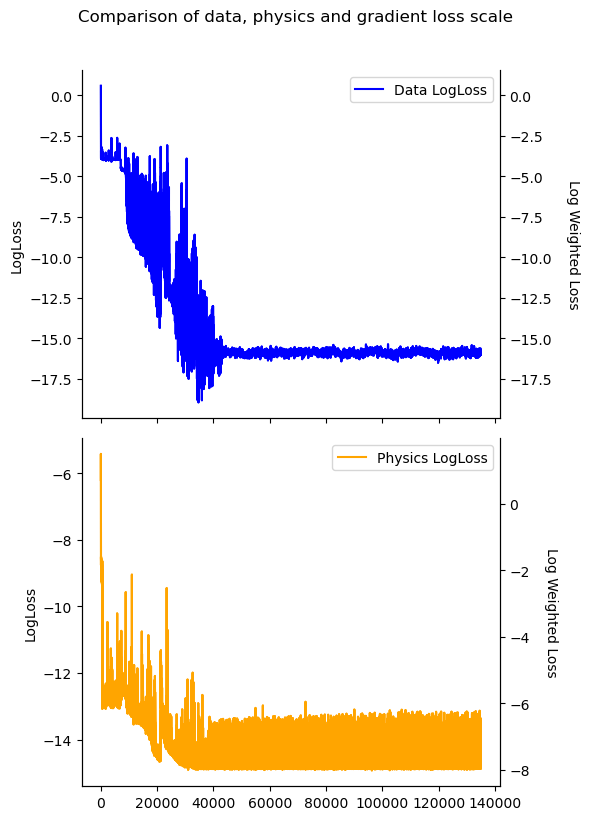

Epoch: 135500
Epoch: 136000
Epoch: 136500
Epoch: 137000
Epoch: 137500
Epoch: 138000
tensor(0.0004, dtype=torch.float64, grad_fn=<AddBackward0>)
0.01
[1.0000000000000004e-08]
Epoch: 138500
Epoch: 139000
Epoch: 139500
Epoch: 140000


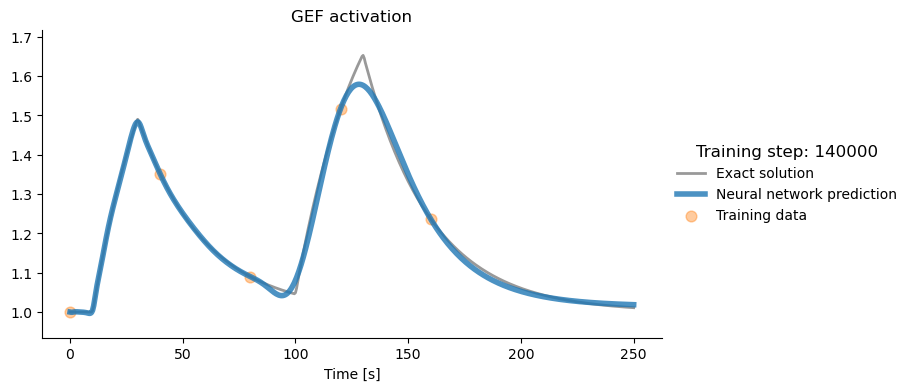

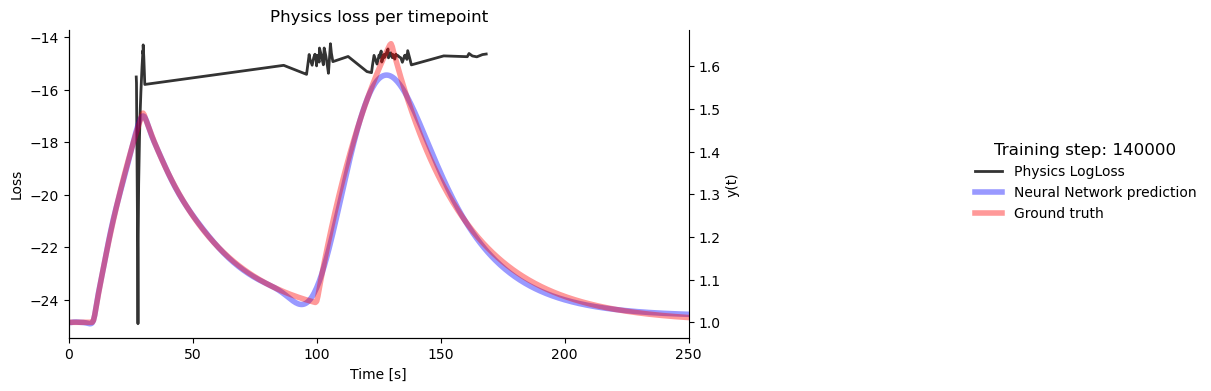

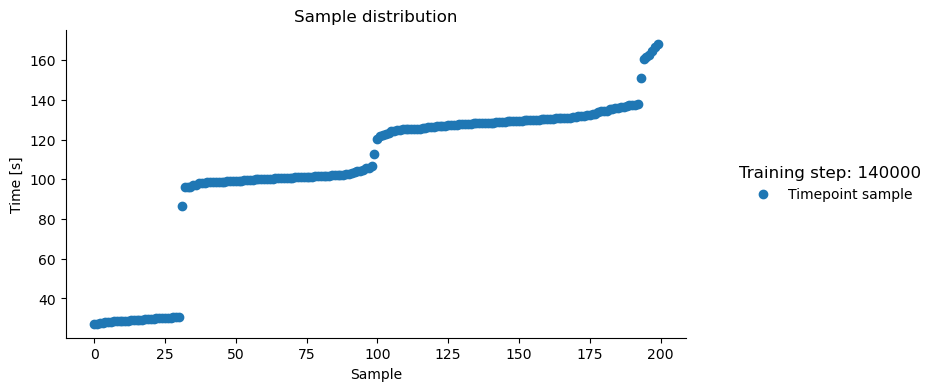

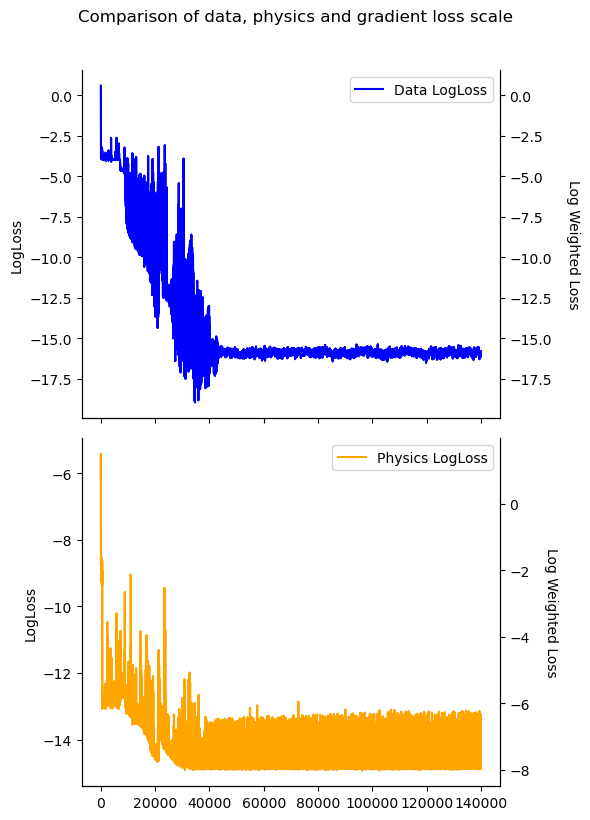

Epoch: 140500
Epoch: 141000
tensor(0.0004, dtype=torch.float64, grad_fn=<AddBackward0>)
0.01
[1.0000000000000004e-08]
Epoch: 141500
Epoch: 142000
Epoch: 142500
Epoch: 143000
Epoch: 143500
Epoch: 144000
tensor(0.0004, dtype=torch.float64, grad_fn=<AddBackward0>)
0.01
[1.0000000000000004e-08]
Epoch: 144500
Epoch: 145000


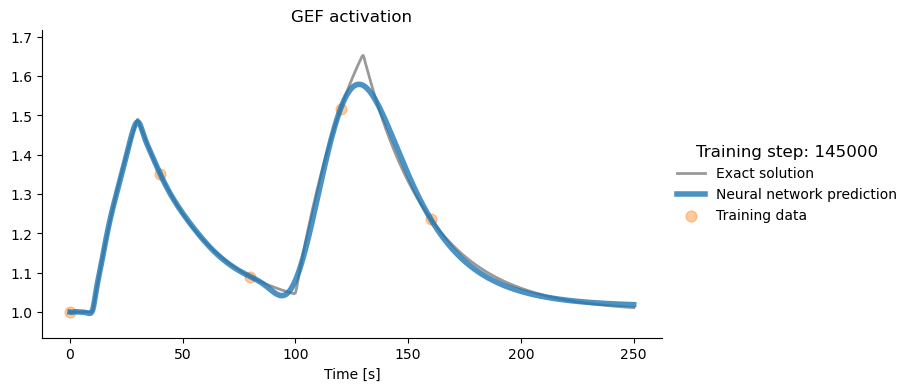

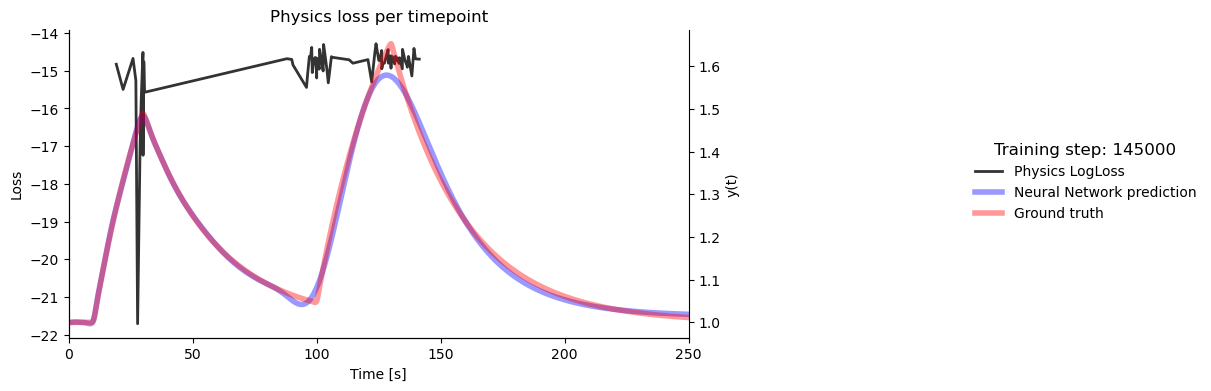

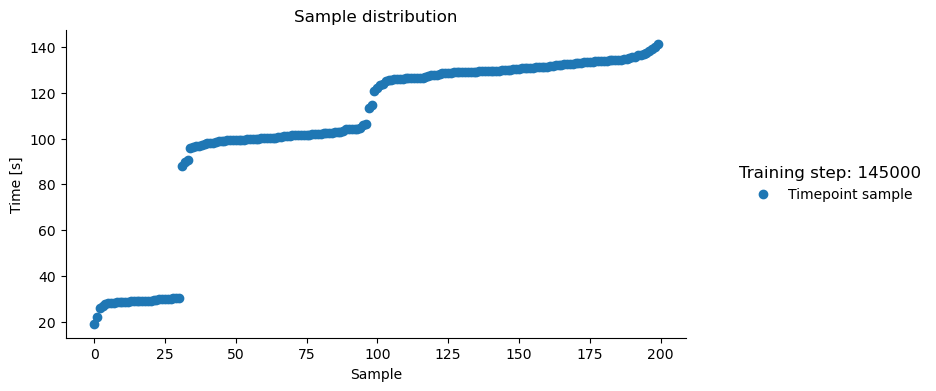

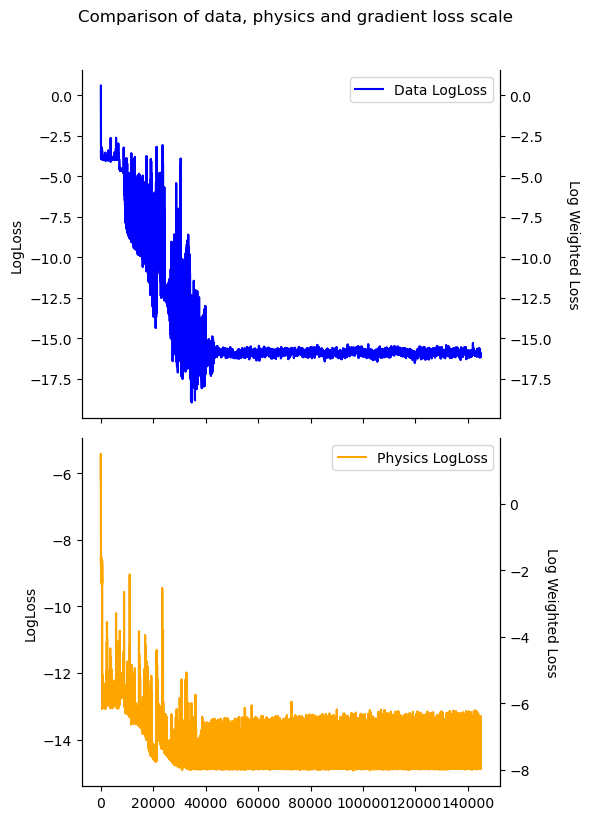

Epoch: 145500
Epoch: 146000
Epoch: 146500
Epoch: 147000
tensor(0.0004, dtype=torch.float64, grad_fn=<AddBackward0>)
0.01
[1.0000000000000004e-08]
Epoch: 147500
Epoch: 148000
Epoch: 148500
Epoch: 149000
Epoch: 149500
Epoch: 150000
tensor(0.0003, dtype=torch.float64, grad_fn=<AddBackward0>)
0.01
[1.0000000000000004e-08]


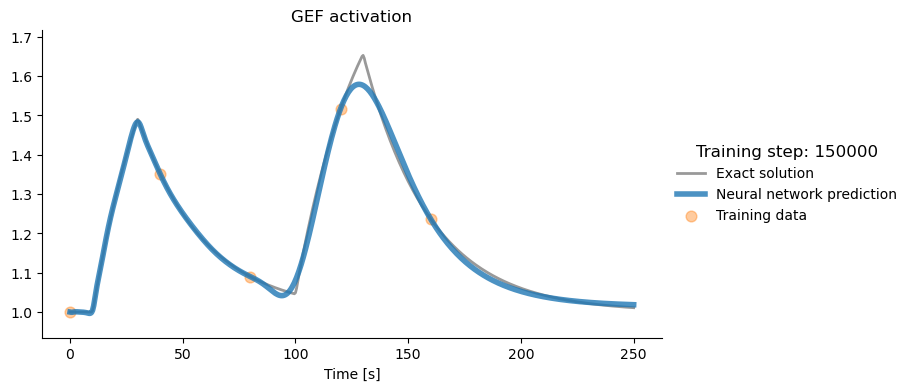

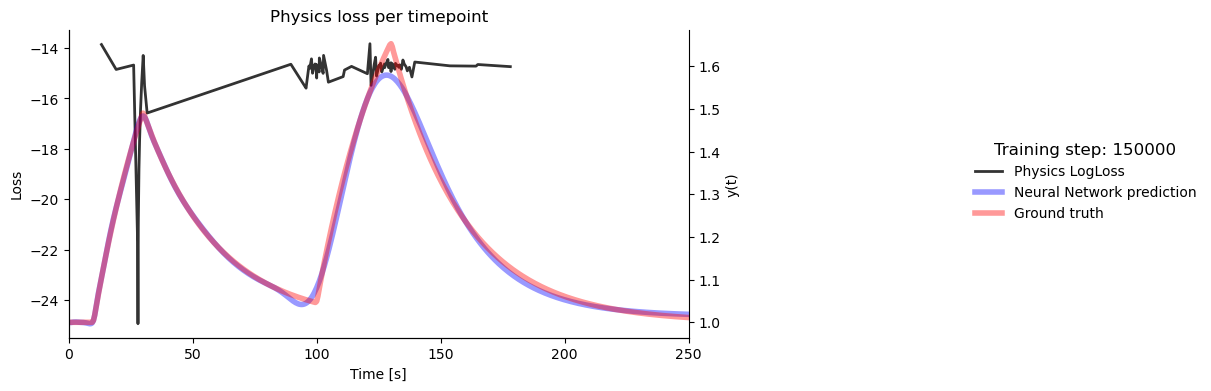

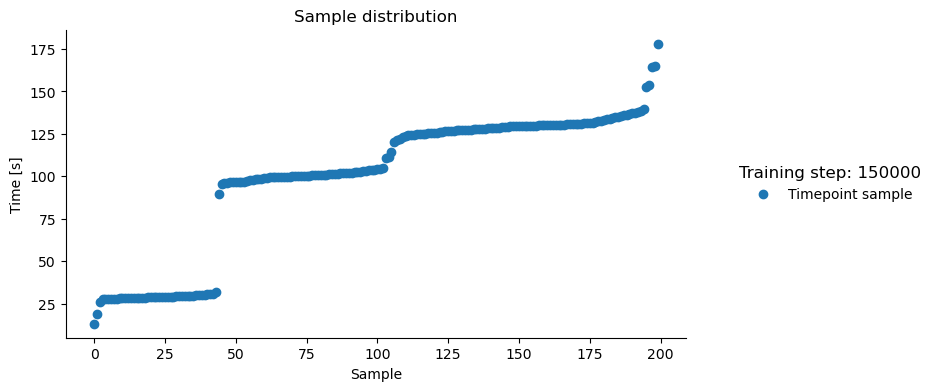

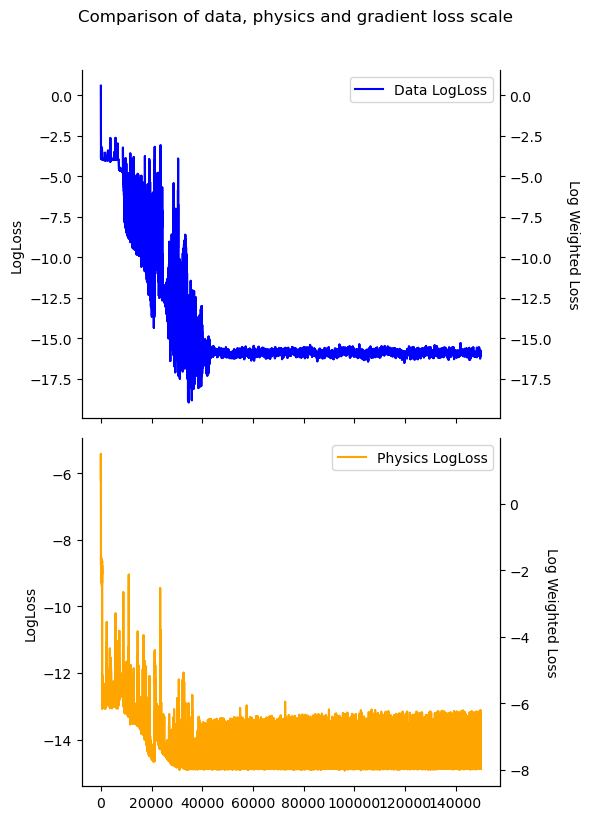

Epoch: 150500
Epoch: 151000
Epoch: 151500
Epoch: 152000
Epoch: 152500
Epoch: 153000
tensor(0.0004, dtype=torch.float64, grad_fn=<AddBackward0>)
0.01
[1.0000000000000004e-08]
Epoch: 153500
Epoch: 154000
Epoch: 154500
Epoch: 155000


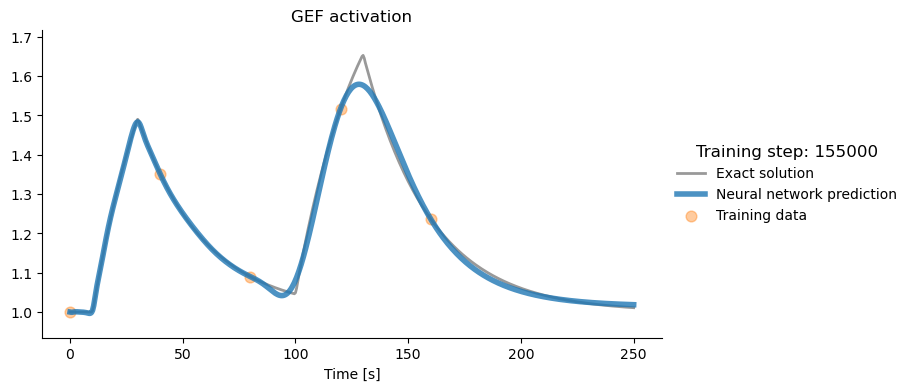

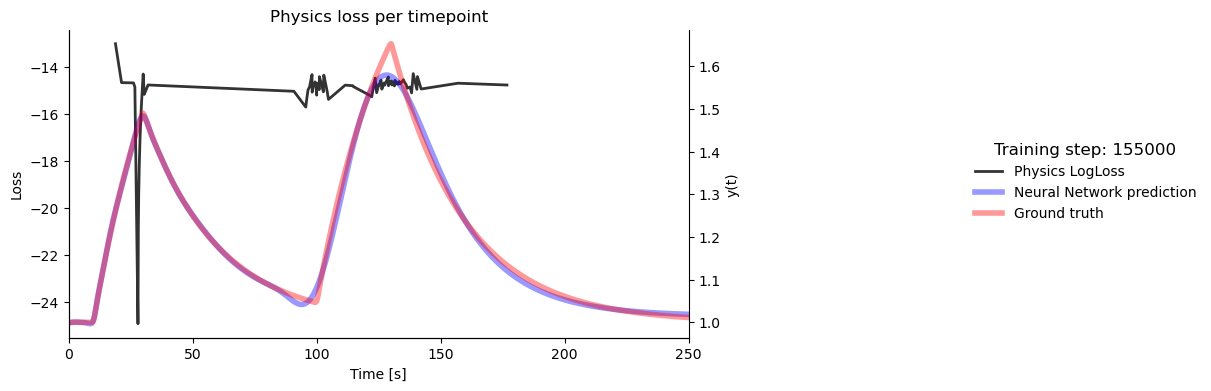

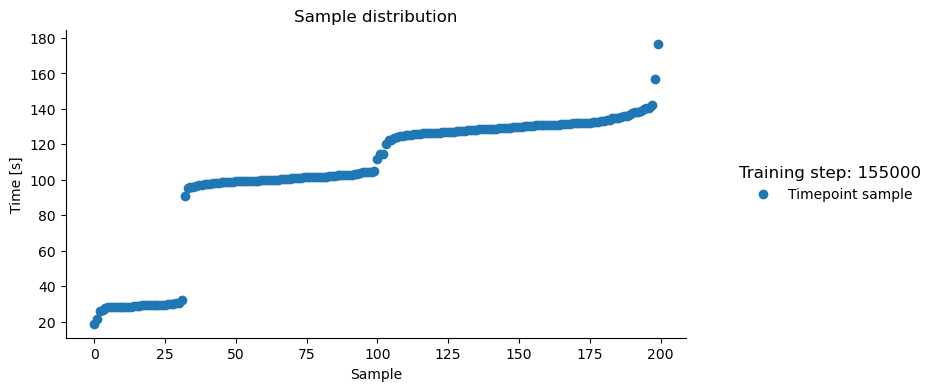

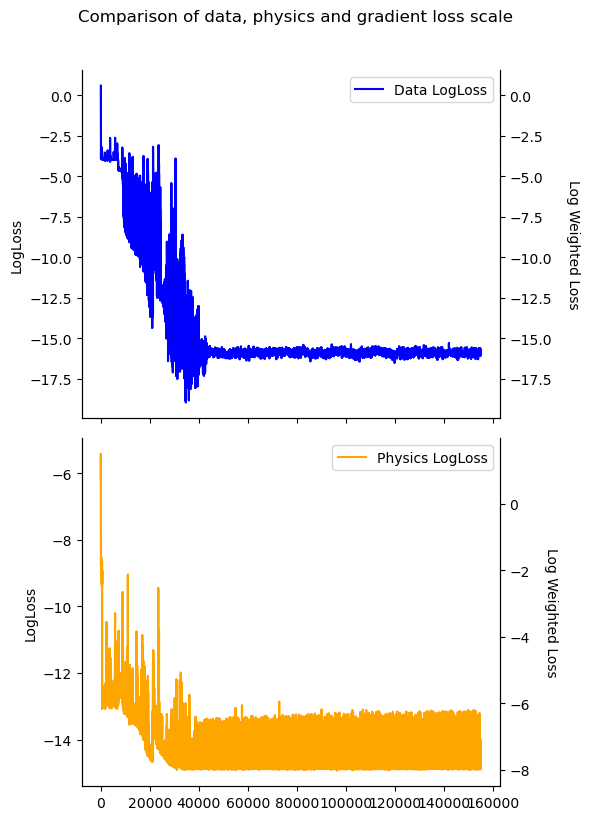

Epoch: 155500
Epoch: 156000
tensor(0.0004, dtype=torch.float64, grad_fn=<AddBackward0>)
0.01
[1.0000000000000004e-08]
Epoch: 156500
Epoch: 157000
Epoch: 157500
Epoch: 158000
Epoch: 158500
Epoch: 159000
tensor(0.0004, dtype=torch.float64, grad_fn=<AddBackward0>)
0.01
[1.0000000000000004e-08]
Epoch: 159500
Epoch: 160000


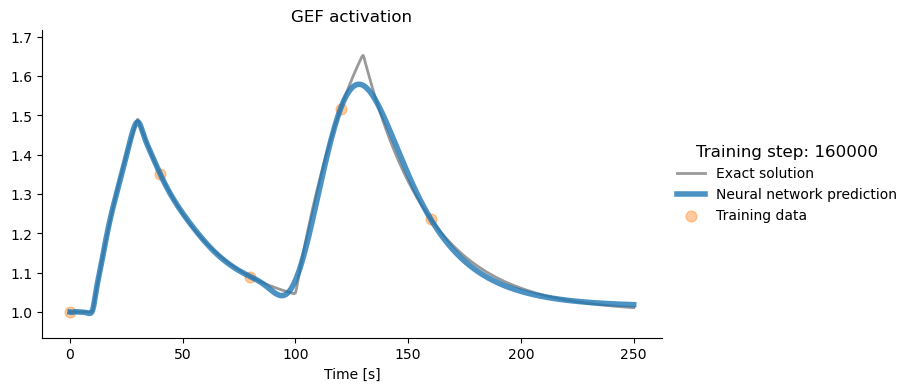

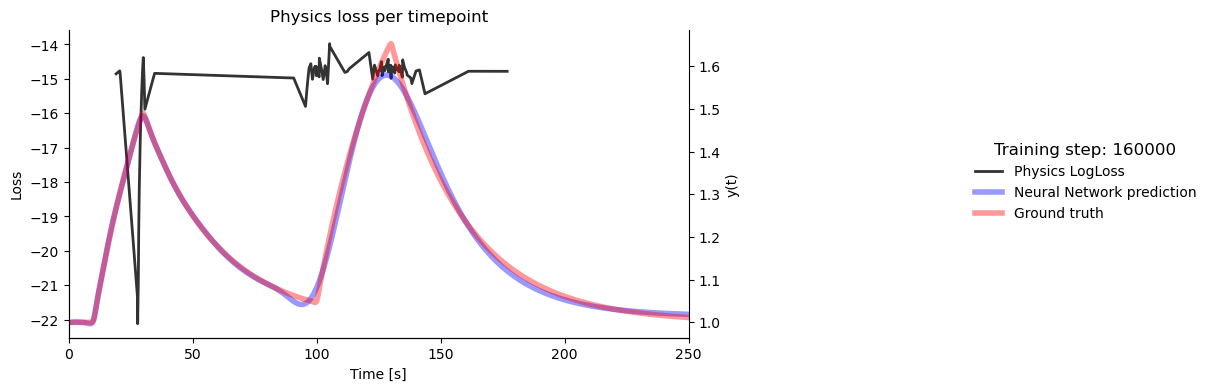

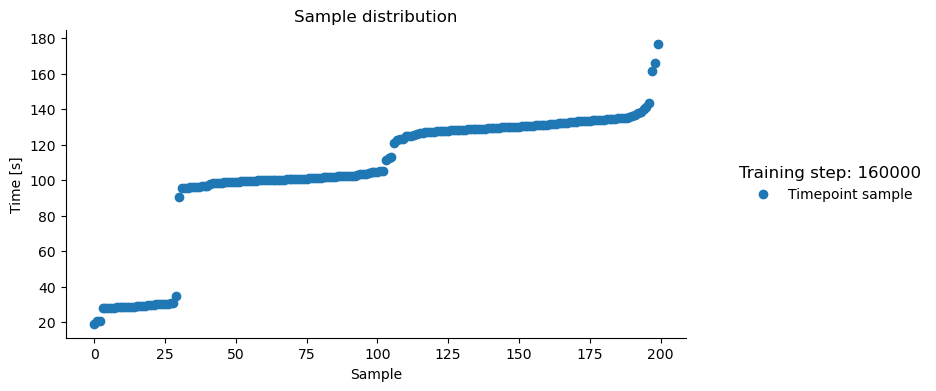

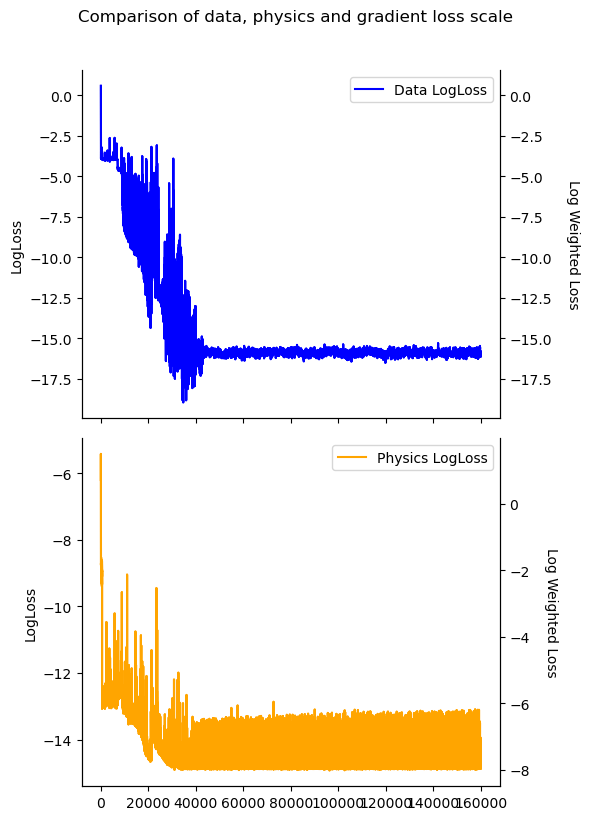

Epoch: 160500
Epoch: 161000
Epoch: 161500
Epoch: 162000
tensor(0.0004, dtype=torch.float64, grad_fn=<AddBackward0>)
0.01
[1.0000000000000004e-08]
Epoch: 162500


In [ ]:
size_batch = 200
size_space = int(1e4)
weights = {"Data": 1, "Physics": 1e3, "Gradient": 0}
n_epochs = int(2.5e5)
ode_param = {'kinact': kinact, 'gef0': gef0, 'light_on': light_on, 'light_off': light_off}
plot_title= "GEF activation"
interval = (torch.max(y, dim=0)[0].item() - torch.min(y, dim=0)[0].item())/10
ylim = (torch.min(y, dim=0)[0].item()-interval, torch.max(y, dim=0)[0].item()+interval)
model, plot_files, loss_files, losses = train_sbinn(t_data, y_data, t, y, 
                                            weights, size_batch, size_space, n_epochs,
                                            gef_residuals, ode_param, plot_title, ylim)

In [232]:
# Enter name to save model and plots
model_name = "gef_RLBL_2x20s_5data_200samples_32w_3d_1wd_1e3wp_0wg"

In [233]:
# Save the training and loss plots as GIF animation
save_gif_PIL("./Models/"+model_name+"_pinn.gif", plot_files, fps=10, loop=2)
save_gif_PIL("./Models/"+model_name+"_loss.gif", loss_files, fps=5, loop=2)
#plot_losses(losses, weights, filename="./Models/"+model_name+"_loss.png")
#save_gif_PIL("./Models/"+model_name+"_sample.gif", sample_files, fps=20, loop=0)

Convergence conditions and remarks:
- increased width (w=64, d=6) led to better convergence for 2 pulses model.
- importance sampling => improvement but still problems in hard-to-fit regions
- better convergence with increased #samples (and importance sampling)
- too deep sample space requires more epochs
- increased oscillation frequency or sharpness of variations cause trouble for convergence (longer pulse => better convergence)
- hard-to-fit points have loss value hard to minimize
- ReLoBRaLo alone did not converge (with importance sampling but (1,1) as initial weight loss)
- ReLoBRaLo with added weight scaling (1, 1e3) seems to converge faster.

To explore:
- LA-PINN
- penalise increase of the max of the loss gradient (avoid trivial solution)
- importance sampling : re-estimate sample space based on distribution proportional to the physics loss.
- alternatives to importance sampling.
- automatic weight learning?

To do:
- save model
- early stopping
- create clear plots for three benchmark ODEs (). With/without correct weights, enough samples, less samples with gradient method. 
- 